
# **Investment Replica**

## **Problem Statement**
We consider the following problem:

- There is a **secret portfolio**, a financial **black-box**, which publicly reports its returns on a regular basis (e.g., weekly, monthly, daily).
- We do **not** know either **which instruments** the portfolio contains or **what weight** each instrument has.
- We **do** know the vast investment vehicles available in the markets, such as **bonds, stocks, ETFs, funds, futures contracts**.
- Even if we don't know how the black-box processes input information, we can observe its **output**, i.e., the time series of returns.

Our goal is to **infer the structure of the black-box**, extracting information about latent variables or functions and structural parameters from observed data.

This notebook shows how to reverse-engineer such black-box portfolios by analyzing their return patterns and finding combinations of liquid instruments that can replicate their performance.

---

## **Dataset Description**
This dataset consists of financial data representing:

- **HFRX Index**: A popular index of **Hedge Funds** ([HFRX Index](https://www.hfr.com/indices)) – for those unfamiliar with hedge funds, see [Wikipedia](https://en.wikipedia.org/wiki/Hedge_fund).
- **MSCI World Index**: Global **Developed Equities** ([MSCI World](https://www.msci.com/acwi)).
- **MSCI World All Country Index**: Global **Equities (Developed and Emerging)** ([MSCI ACWI](https://www.msci.com/acwi)).
- **Barclays Bloomberg Global Aggregate Bond Index**: **Global Bonds** (Developed & Emerging, Govt & Corporate) ([Bloomberg](https://www.bloomberg.com/quote/LEGATRUU:IND)).
- **A broad range of Futures contracts** on equity indices, benchmark bonds, currencies, and commodities.

### **Available Futures Contracts**
| Symbol | Instrument |
|--------|------------------|
| RX1    | Bund (10 Yrs Ger) |
| CO1    | Brent (Oil) |
| DU1    | Schatz (2yrs Gvt Ger) |
| ES1    | S&P 500 (US Equity) |
| GC1    | Gold |
| LLL1   | MSCI Emerging Markets (EM Equity) |
| NQ1    | Nasdaq 100 (Tech Equity) |
| TP1    | Topix (Japanese Equity) |
| TU2    | 2Yrs US Treasury (US Govt) |
| TY1    | 10Yrs US Treasury (US Govt) |
| VG1    | Eurostoxx 50 (EU Equity) |

### **Additional Dataset Information**
- **Source**: Bloomberg.
- **Frequency**: Weekly data in local currency.
- **Format**: Original, raw format (but mostly clean).
- **Time Period**: October 2007 – April 2021.

---

## **Who Replicates What?**
To conduct a challenging exercise in **index replication** and explore **financial analytics**, we will attempt to replicate a **"monster index"** that we construct ourselves combining different indexes. This index will include:
- **Tens of thousands** of securities at a micro level.
- A **non-investable** black-box combination of stocks, bonds, and hedge funds.
- A **multi-currency** structure.

To create our **clone**, we will use **Futures contracts (long-short, possibly leveraging them)** because they are:
- **Cheap** ([Cost comparison](https://www.cmegroup.com/trading/equity-index/report-a-cost-comparison-of-futures-and-etfs.html#)).
- **Liquid** and **easy-to-use**.
- **Covering almost everything** ([Futures overview](https://www.marketwatch.com/tools/futures)).

For those new to finance, see: [A Trader’s Guide to Futures](https://www.cmegroup.com/education/files/a-traders-guide-to-futures.pdf).

---

**Alternative Replication Approaches**
Alternatively, you might replicate any linear combination of: HFRX Hedge Fund Index,MSCI World, MSCI ACWI, and Barclays Bloomberg Global Aggregate Bond Index.

This exercise will help us understand **index replication techniques** and gain insights into **financial market structures**.

<br>

As usual, let's start with **data ingestion and preprocessing**.

<br>


In [9]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Mount Google Drive to access files
# Skip remounting if already mounted
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive already mounted or not in Colab environment.")


Mounted at /content/drive


In [47]:
# Define the path to the dataset
file_path = '/content/drive/MyDrive/PoliMI/Dataset3_PortfolioReplicaStrategy.xlsx'

# Reading the Excel file with specific structure:
# - Row 4 contains full names
# - Row 6 contains Bloomberg tickers (note: Excel is 1-indexed, pandas is 0-indexed)
# - Data starts from row 7

# Read full names (row 4)
full_names_df = pd.read_excel(file_path, header=None, skiprows=3, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Read Bloomberg tickers (row 6)
tickers_df = pd.read_excel(file_path, header=None, skiprows=5, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Create a dictionary mapping tickers to full names
variable_info = dict(zip(tickers, full_names))

# Read the actual data without using any row as a header
data_raw = pd.read_excel(file_path, header=None, skiprows=6)

# First column is the date column
data_raw.columns = ['Date'] + tickers  # Assign the columns correctly using tickers

# Set the date column as the index and ensure it's in datetime format
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d/%m/%Y')
data = data_raw.set_index('Date')

# Display the first few rows to examine the dataset structure
print("Dataset preview:")
display(data.head())

# Show the variable information (Ticker -> Full Name)
print("\nVariable Information (Bloomberg Ticker -> Full Name):")
for ticker, name in variable_info.items():
    print(f"{ticker} -> {name}")

# Show basic information about the dataset
print("\nDataset information:")
display(data.info())

# Display statistical summary of the dataset
print("\nBasic statistics:")
display(data.describe())


Dataset preview:


,MXWO Index,MXWD Index,LEGATRUU Index,HFRXGL Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,LLL1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
Date,,,,,,,,,,,,,,,
2011-03-16,1260.15,324.03,430.7737,1218.60,123.65,122.468750,1396.1,110.62,99.79,146.6,99.93,1079.9,16.38,107.790,109.468750
2011-03-23,1311.62,336.56,430.7342,1218.56,122.30,119.968750,1438.0,115.55,99.75,146.6,99.93,1123.0,16.77,107.355,109.281250
2011-03-30,1335.98,343.42,427.2604,1219.79,121.43,119.125000,1423.8,115.13,99.74,146.6,99.93,1159.6,18.01,107.235,109.031250
2011-04-06,1348.86,348.05,427.0089,1226.61,120.62,118.375000,1457.7,122.30,99.72,146.6,99.93,1204.2,22.38,107.085,108.367188
2011-04-13,1338.75,345.07,430.8054,1227.32,120.47,119.390625,1454.9,122.88,99.71,146.6,99.93,1178.2,24.75,107.040,108.640625



Variable Information (Bloomberg Ticker -> Full Name):
MXWO Index -> MSCI WORLD
MXWD Index -> MSCI ACWI
LEGATRUU Index -> Global Aggregate
HFRXGL Index -> Hedge Fund Research HFRX Globa
RX1 Comdty -> Generic 1st 'RX' Future
TY1 Comdty -> Generic 1st 'TY' Future
GC1 Comdty -> Generic 1st 'GC' Future
CO1 Comdty -> Generic 1st 'CO' Future
ES1 Comdty -> Generic 1st 'ES' Future
VG1 Comdty -> Generic 1st 'VG' Future
NQ1 Comdty -> Generic 1st 'NQ' Future
LLL1 Comdty -> Generic 1st 'LLL' Future
TP1 Comdty -> Generic 1st 'TP' Future
DU1 Comdty -> Generic 1st 'DU' Future
TU2 Comdty -> Generic 2nd 'TU' Future

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2011-03-16 to 2021-03-17
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MXWO Index      523 non-null    float64
 1   MXWD Index      523 non-null    float64
 2   LEGATRUU Index  523 non-null    float64
 3   HFRXGL Index    52

None


Basic statistics:


,MXWO Index,MXWD Index,LEGATRUU Index,HFRXGL Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,LLL1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
count,523.00000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,5.230000e+02,5.230000e+02,523.000000,523.000000,523.000000,523.000000
mean,1788.32870,436.423480,473.623764,1218.839465,155.834933,128.220483,1410.428872,75.467361,100.465698,1.466000e+02,9.993000e+01,1104.931166,15.985201,111.290507,108.890057
std,378.31997,85.532166,28.743476,58.513097,13.578955,5.158133,223.964881,27.942695,0.390721,5.689784e-14,2.560403e-13,9.906262,6.827778,1.069653,1.457477
min,1096.16000,277.100000,427.008900,1106.050000,120.470000,117.750000,1054.200000,20.370000,99.710000,1.466000e+02,9.993000e+01,1079.900000,0.190000,107.025000,105.109375
25%,1519.55500,373.540000,452.327450,1183.500000,143.580000,124.851562,1244.100000,51.840000,100.000000,1.466000e+02,9.993000e+01,1103.600000,13.250000,110.647500,108.058594
50%,1735.35000,422.250000,467.764100,1221.120000,159.050000,127.515625,1319.300000,65.840000,100.720000,1.466000e+02,9.993000e+01,1103.600000,13.250000,111.805000,109.343750
75%,2089.29500,504.475000,483.861550,1251.500000,164.890000,131.414062,1596.300000,107.735000,100.760000,1.466000e+02,9.993000e+01,1103.600000,19.175000,112.060000,110.109375
max,2823.69000,682.700000,558.970300,1411.540000,179.300000,140.078125,2031.100000,125.130000,100.980000,1.466000e+02,9.993000e+01,1207.300000,37.210000,112.720000,110.515625



# **Data Exploration**

Let's analyze the potential replication targets to understand their characteristics.



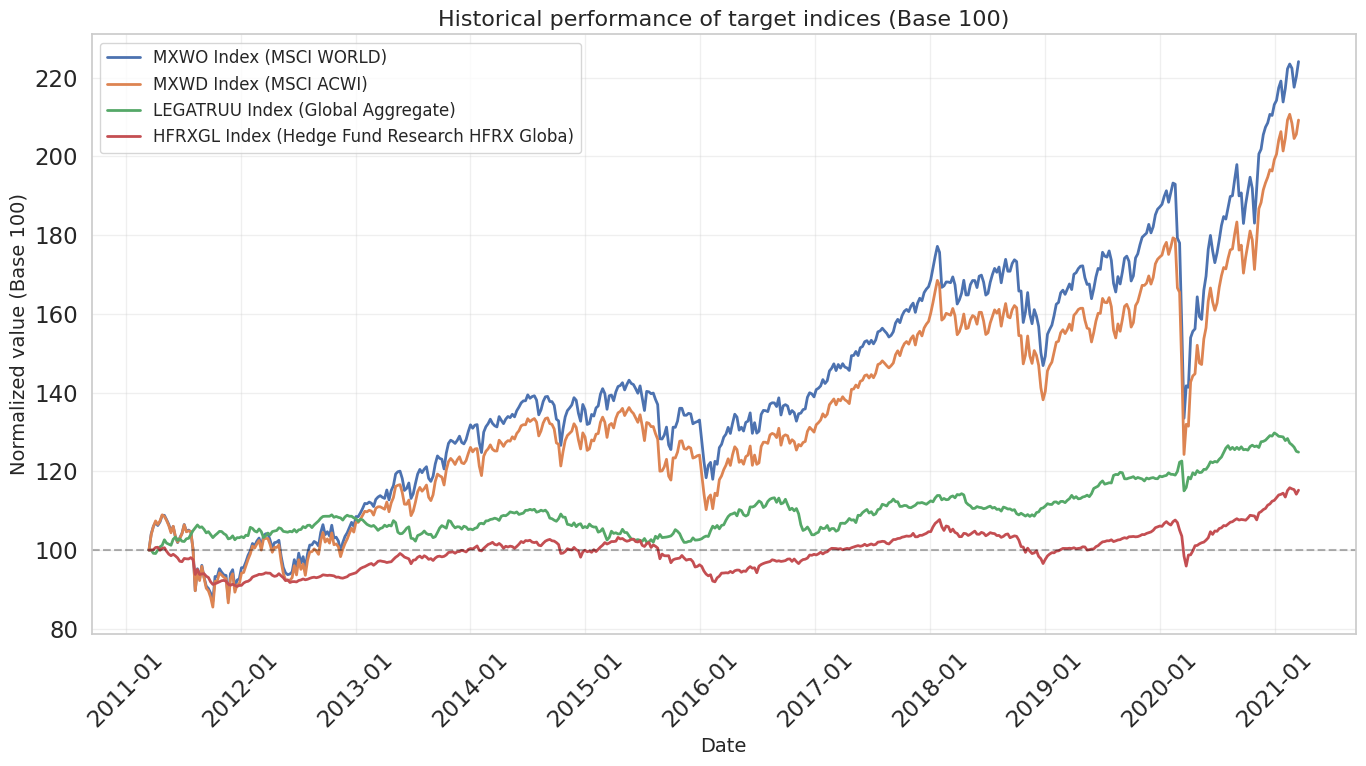


Return statistics for target indices:


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
MXWO Index,9.24%,15.35%,0.601969,-30.91%,-1.248631,8.356921
MXWD Index,8.56%,15.39%,0.556476,-30.69%,-1.255392,8.200100
LEGATRUU Index,2.34%,5.00%,0.468095,-8.30%,-1.485628,12.859569
HFRXGL Index,1.52%,4.57%,0.331591,-10.97%,-1.783691,11.163555


In [48]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Target indices to explore
target_indices = ['MXWO Index', 'MXWD Index', 'LEGATRUU Index', 'HFRXGL Index']

# Create a figure for the historical price series
plt.figure(figsize=(14, 8))

# Plot each index
for idx in target_indices:
    # Normalize to 100 at the beginning for comparison
    normalized_series = data[idx] / data[idx].iloc[0] * 100
    plt.plot(normalized_series.index, normalized_series, linewidth=2, label=f"{idx} ({variable_info.get(idx, idx)})")

# Format the plot
plt.title('Historical performance of target indices (Base 100)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Normalized value (Base 100)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Add a horizontal line at y=100
plt.axhline(y=100, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display statistics for all indices
print("\nReturn statistics for target indices:")
# Calculate returns
returns = data[target_indices].pct_change().dropna()

# Calculate annualized statistics (assuming weekly data)
annual_factor = 52  # For weekly data (52 weeks = 1 year)

# Format as percentage with 2 decimal places
def format_pct(x):
    return f"{x*100:.2f}%"

stats = pd.DataFrame({
    'Annualized Return': returns.mean() * annual_factor,
    'Annualized Volatility': returns.std() * np.sqrt(annual_factor),
    'Sharpe Ratio': (returns.mean() * annual_factor) / (returns.std() * np.sqrt(annual_factor)),
    'Max Drawdown': returns.apply(lambda x: (1 + x).cumprod().div((1 + x).cumprod().cummax()) - 1).min(),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
})

# Convert some columns to percentage format for better readability
for col in ['Annualized Return', 'Annualized Volatility', 'Max Drawdown']:
    stats[col] = stats[col].apply(format_pct)

display(stats)


### Correlation & probability distribution analysis
Understanding the shape and the relationships between different indices helps us understanding the behavior of our ingredients and identify potential replication components.

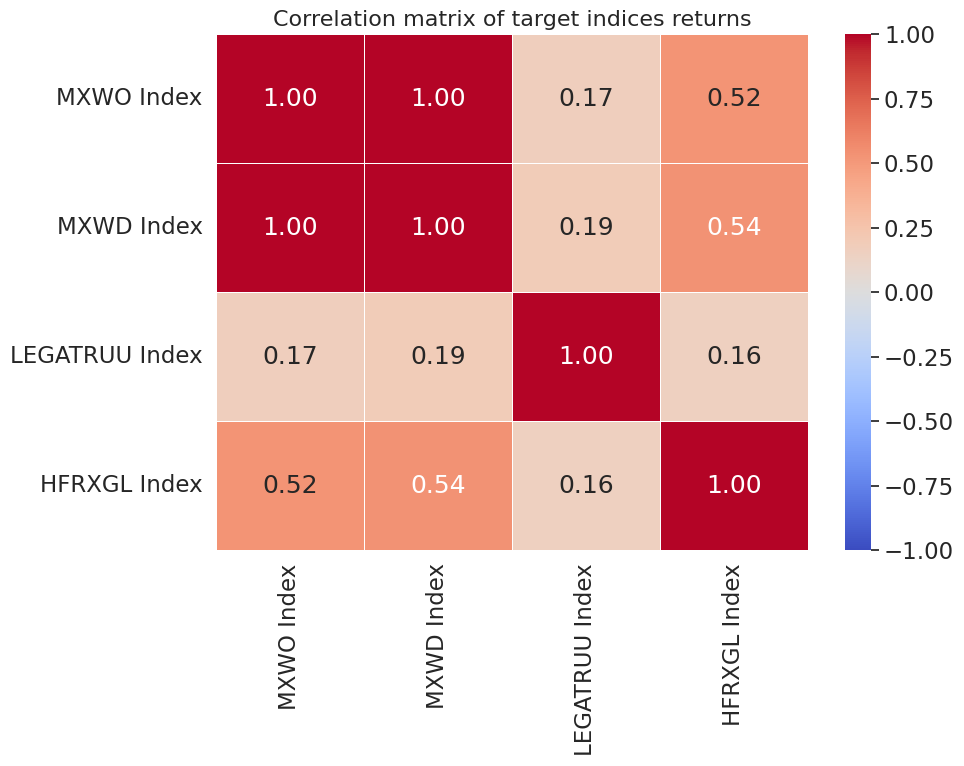

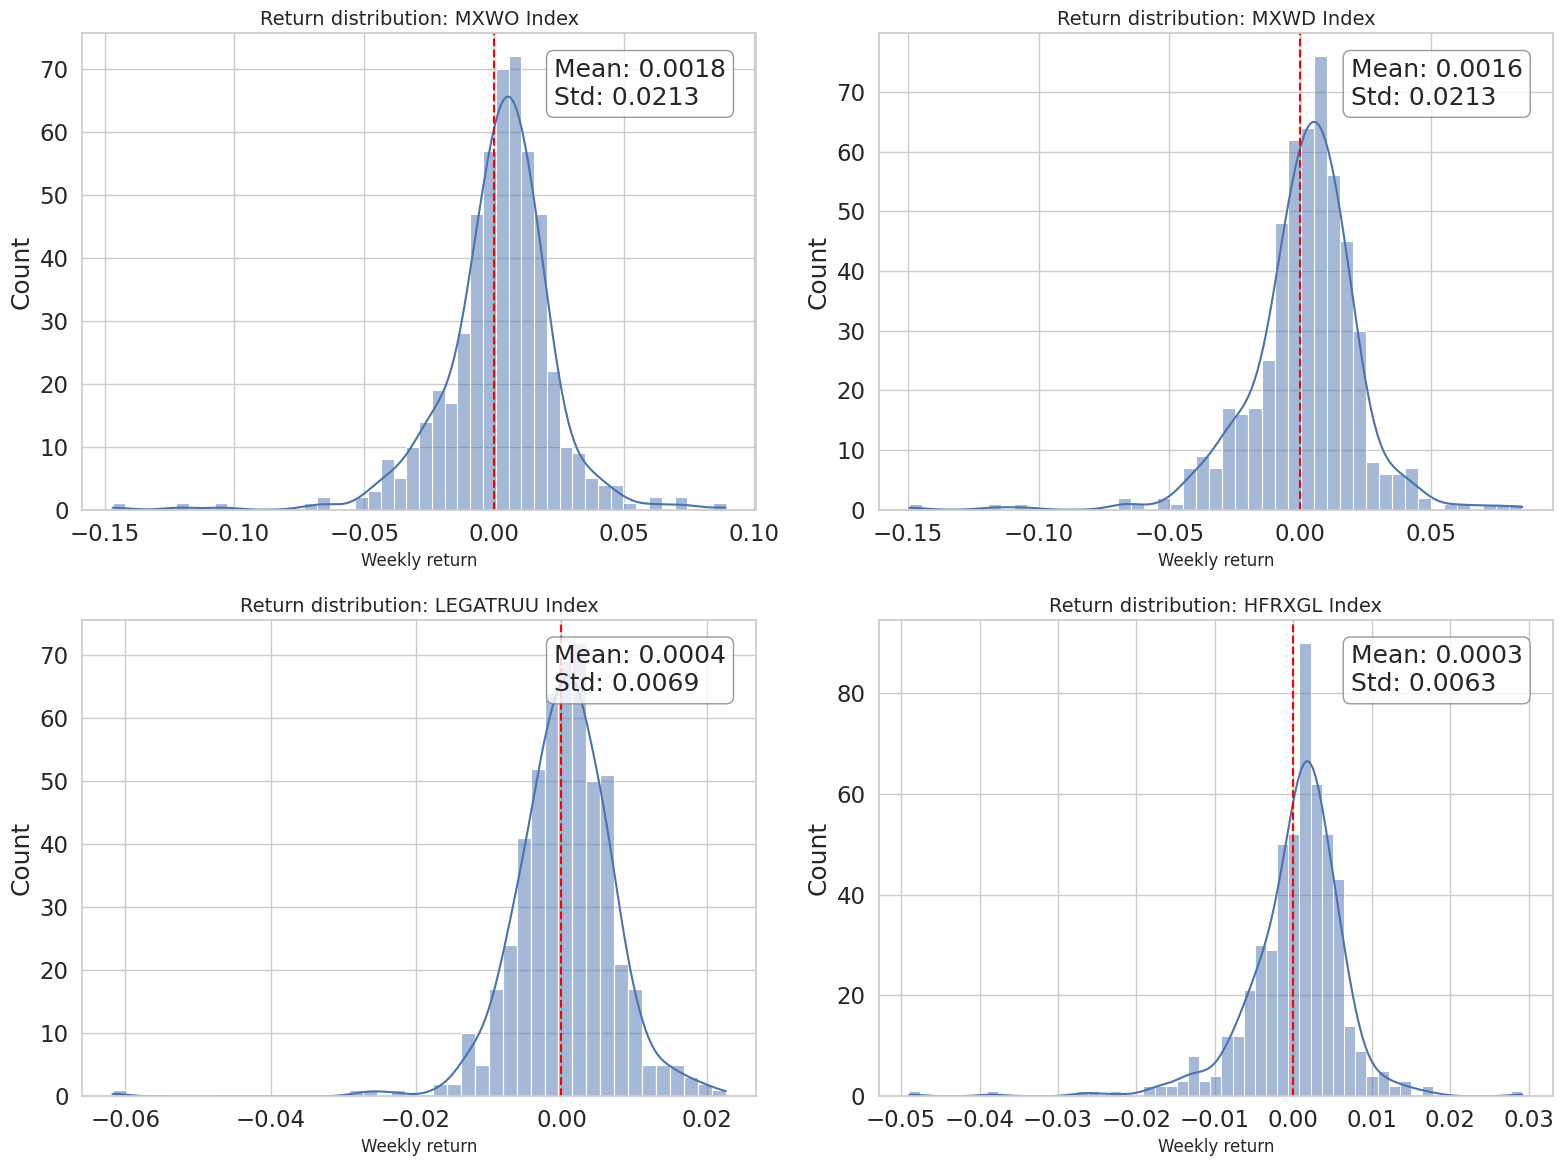

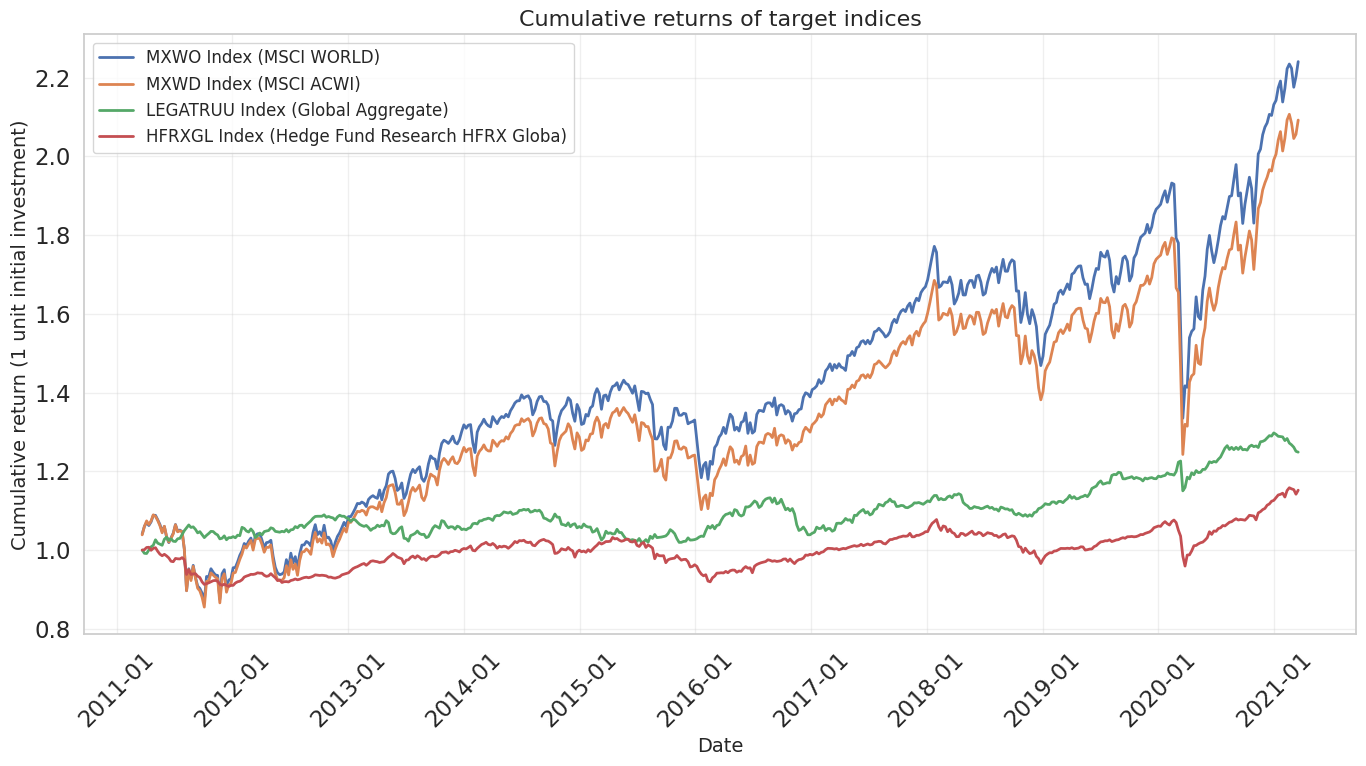

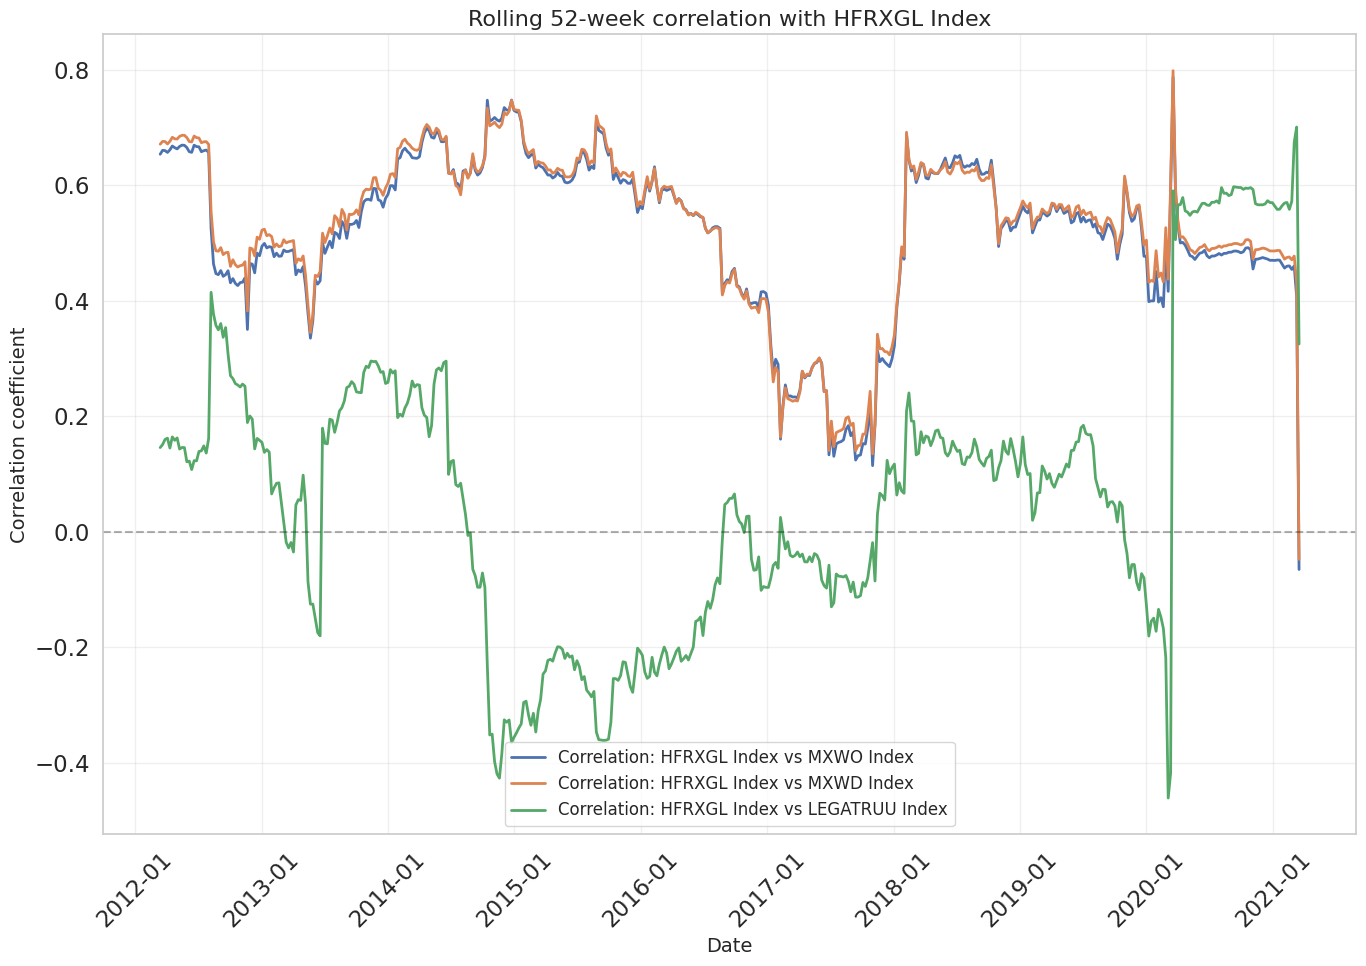

In [49]:
# Create a correlation heatmap for the target indices
plt.figure(figsize=(10, 8))
correlation_matrix = returns[target_indices].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, fmt='.2f')
plt.title('Correlation matrix of target indices returns', fontsize=16)
plt.tight_layout()
plt.show()

# Plot returns distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, idx in enumerate(target_indices):
    sns.histplot(returns[idx], kde=True, ax=axes[i])
    axes[i].set_title(f'Return distribution: {idx}', fontsize=14)
    axes[i].set_xlabel('Weekly return', fontsize=12)
    axes[i].axvline(x=0, color='red', linestyle='--')
    # Add mean and std annotations
    mean = returns[idx].mean()
    std = returns[idx].std()
    axes[i].annotate(f'Mean: {mean:.4f}\nStd: {std:.4f}',
                     xy=(0.7, 0.85), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Compute cumulative returns for visualization
cumulative_returns = (1 + returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for idx in target_indices:
    plt.plot(cumulative_returns.index, cumulative_returns[idx], linewidth=2,
             label=f"{idx} ({variable_info.get(idx, idx)})")

plt.title('Cumulative returns of target indices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative return (1 unit initial investment)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot rolling correlations over time (12-month window)
rolling_window = 52  # 52 weeks ≈ 1 year
plt.figure(figsize=(14, 10))

# Base correlation against HFRXGL (Hedge Fund Index)
base_idx = 'HFRXGL Index'
for idx in [i for i in target_indices if i != base_idx]:
    roll_corr = returns[[base_idx, idx]].rolling(rolling_window).corr().unstack()[base_idx][idx]
    plt.plot(roll_corr.index, roll_corr, linewidth=2,
             label=f"Correlation: {base_idx} vs {idx}")

plt.title(f'Rolling {rolling_window}-week correlation with {base_idx}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Correlation coefficient', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<br>

Let's examine the statistical properties of our target indices.


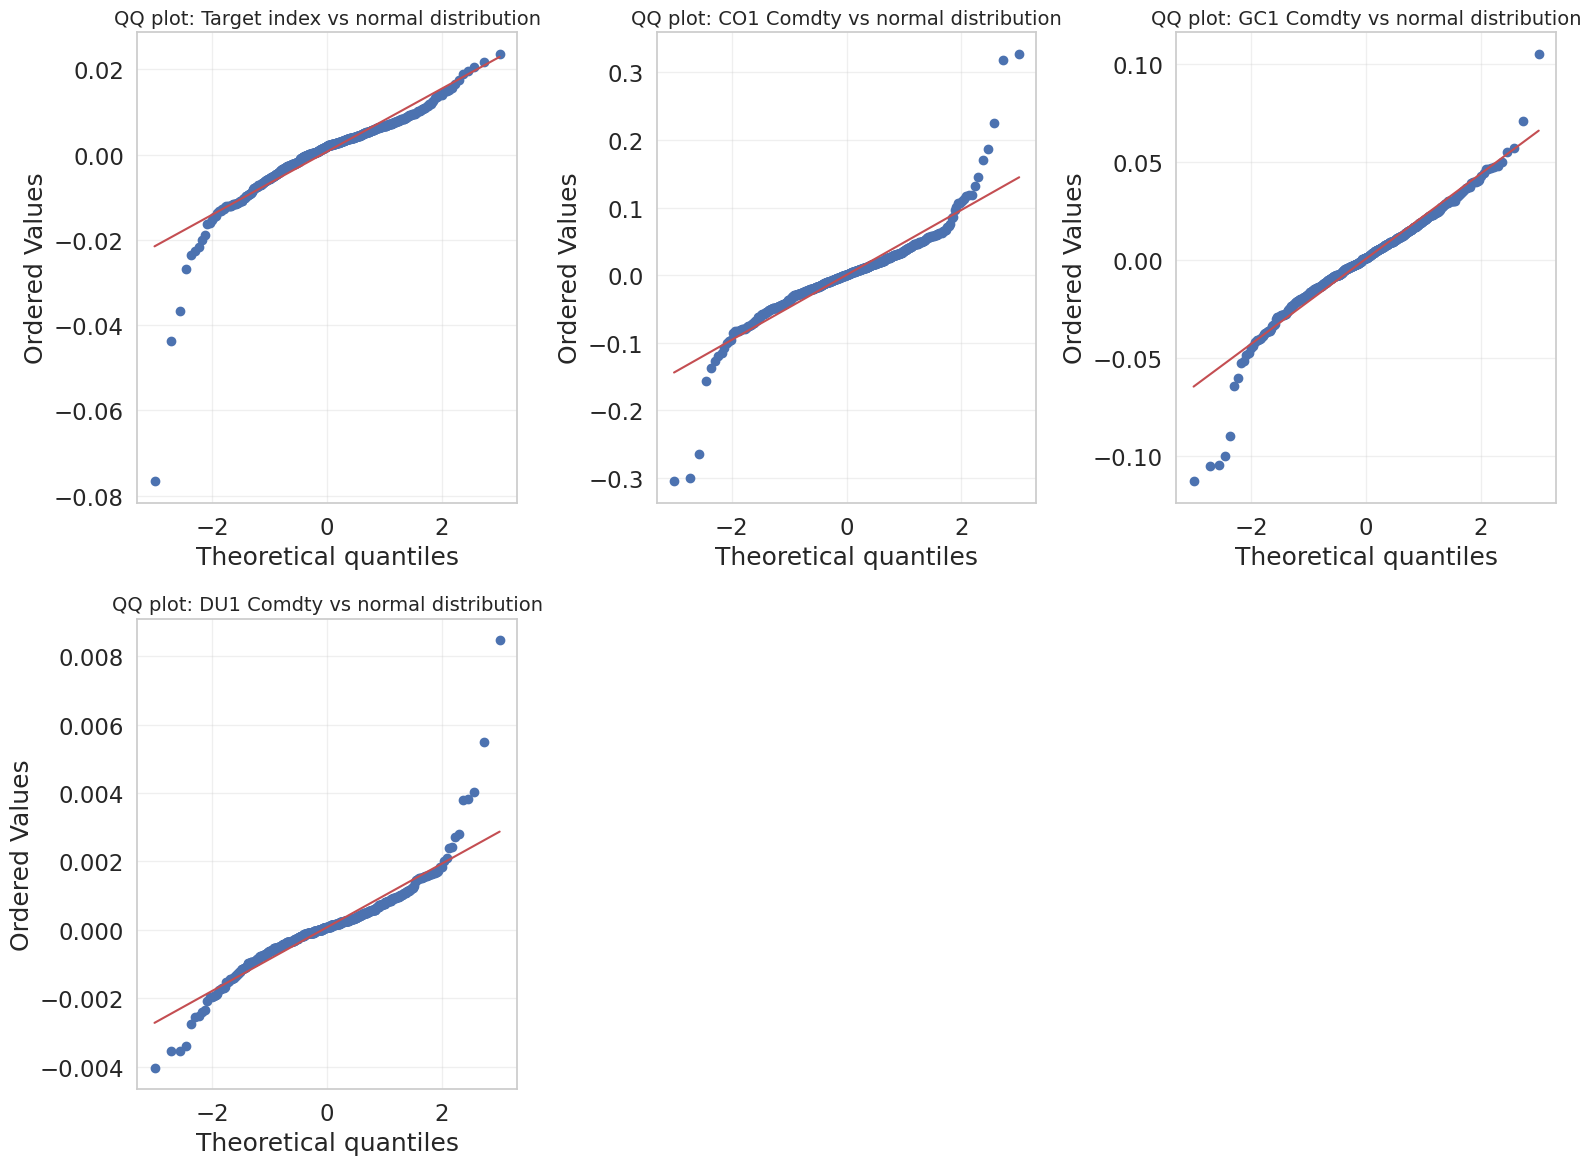

In [50]:
# Some QQ plots for key variables
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
import warnings

# Suppress specific boring RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

# Define the components of our target index with their weights
# You can be creative, this is just an example
# Monster Index (a crazy combination of large indexes)
index_components = {
    'HFRXGL Index': 0.50,   # Hedge Fund Index - 50%
    'MXWO Index': 0.25,     # MSCI World - 25%
    'LEGATRUU Index': 0.25  # Global Aggregate Bond - 25%
}

# Calculate returns for each component
component_returns = data[list(index_components.keys())].pct_change().dropna()

# Create the target index using weighted returns
weighted_returns = pd.DataFrame(index=component_returns.index)
for component, weight in index_components.items():
    weighted_returns[component] = component_returns[component] * weight

# Sum the weighted returns to get the target index returns
target_returns = weighted_returns.sum(axis=1)
target_returns.name = 'Target_Index'

# Define the futures contracts we'll use for replication
futures_contracts = [
    'RX1 Comdty', 'TY1 Comdty', 'GC1 Comdty', 'CO1 Comdty',
    'ES1 Comdty', 'VG1 Comdty', 'NQ1 Comdty', 'LLL1 Comdty',
    'TP1 Comdty', 'DU1 Comdty', 'TU2 Comdty'
]

# Calculate returns for futures contracts
futures_returns = data[futures_contracts].pct_change().dropna()

# Ensure we're using the same date range for both target and futures
common_dates = futures_returns.index.intersection(target_returns.index)
futures_returns = futures_returns.loc[common_dates]
target_returns_aligned = target_returns.loc[common_dates]

# Calculate correlations between target index and futures contracts using pandas method
# which handles NaN values better than np.corrcoef
correlations = pd.DataFrame(index=futures_contracts,
                           columns=['Correlation with target index'])

for contract in futures_contracts:
    correlations.loc[contract] = target_returns_aligned.corr(futures_returns[contract])

# Sort by absolute correlation value
correlations['Abs correlation'] = correlations['Correlation with target index'].abs()
correlations = correlations.sort_values('Abs correlation', ascending=False)
correlations = correlations.drop('Abs correlation', axis=1)

# Now create the QQ plots
plt.figure(figsize=(16, 12))

# Plot QQ plot for the target index
plt.subplot(2, 3, 1)
stats.probplot(target_returns_aligned.dropna(), dist="norm", plot=plt)
plt.title(f'QQ plot: Target index vs normal distribution', fontsize=14)
plt.grid(True, alpha=0.3)

# Select a few key futures contracts (top 3 by correlation with target)
top_futures = correlations.index[:3].tolist()

# Create QQ plots for top futures
for i, contract in enumerate(top_futures):
    plt.subplot(2, 3, i+2)

    # Get returns data for this contract
    returns_data = futures_returns[contract].dropna()

    # Create QQ plot
    stats.probplot(returns_data, dist="norm", plot=plt)

    # Add title and improve appearance
    plt.title(f'QQ plot: {contract} vs normal distribution', fontsize=14)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [51]:
# Print the top correlated futures, just for reference
print("Top futures contracts by correlation with target index:")
display(correlations.head())

Top futures contracts by correlation with target index:


,Correlation with target index
CO1 Comdty,0.476124
GC1 Comdty,0.238637
DU1 Comdty,-0.187499
TU2 Comdty,-0.14868
ES1 Comdty,-0.116307


<br>

We'll analyze the **autocorrelation** properties of our target indices to understand their time series behavior. It is possible to take this into account in modelling, and in any case it is better to know what the situation is.

<br>

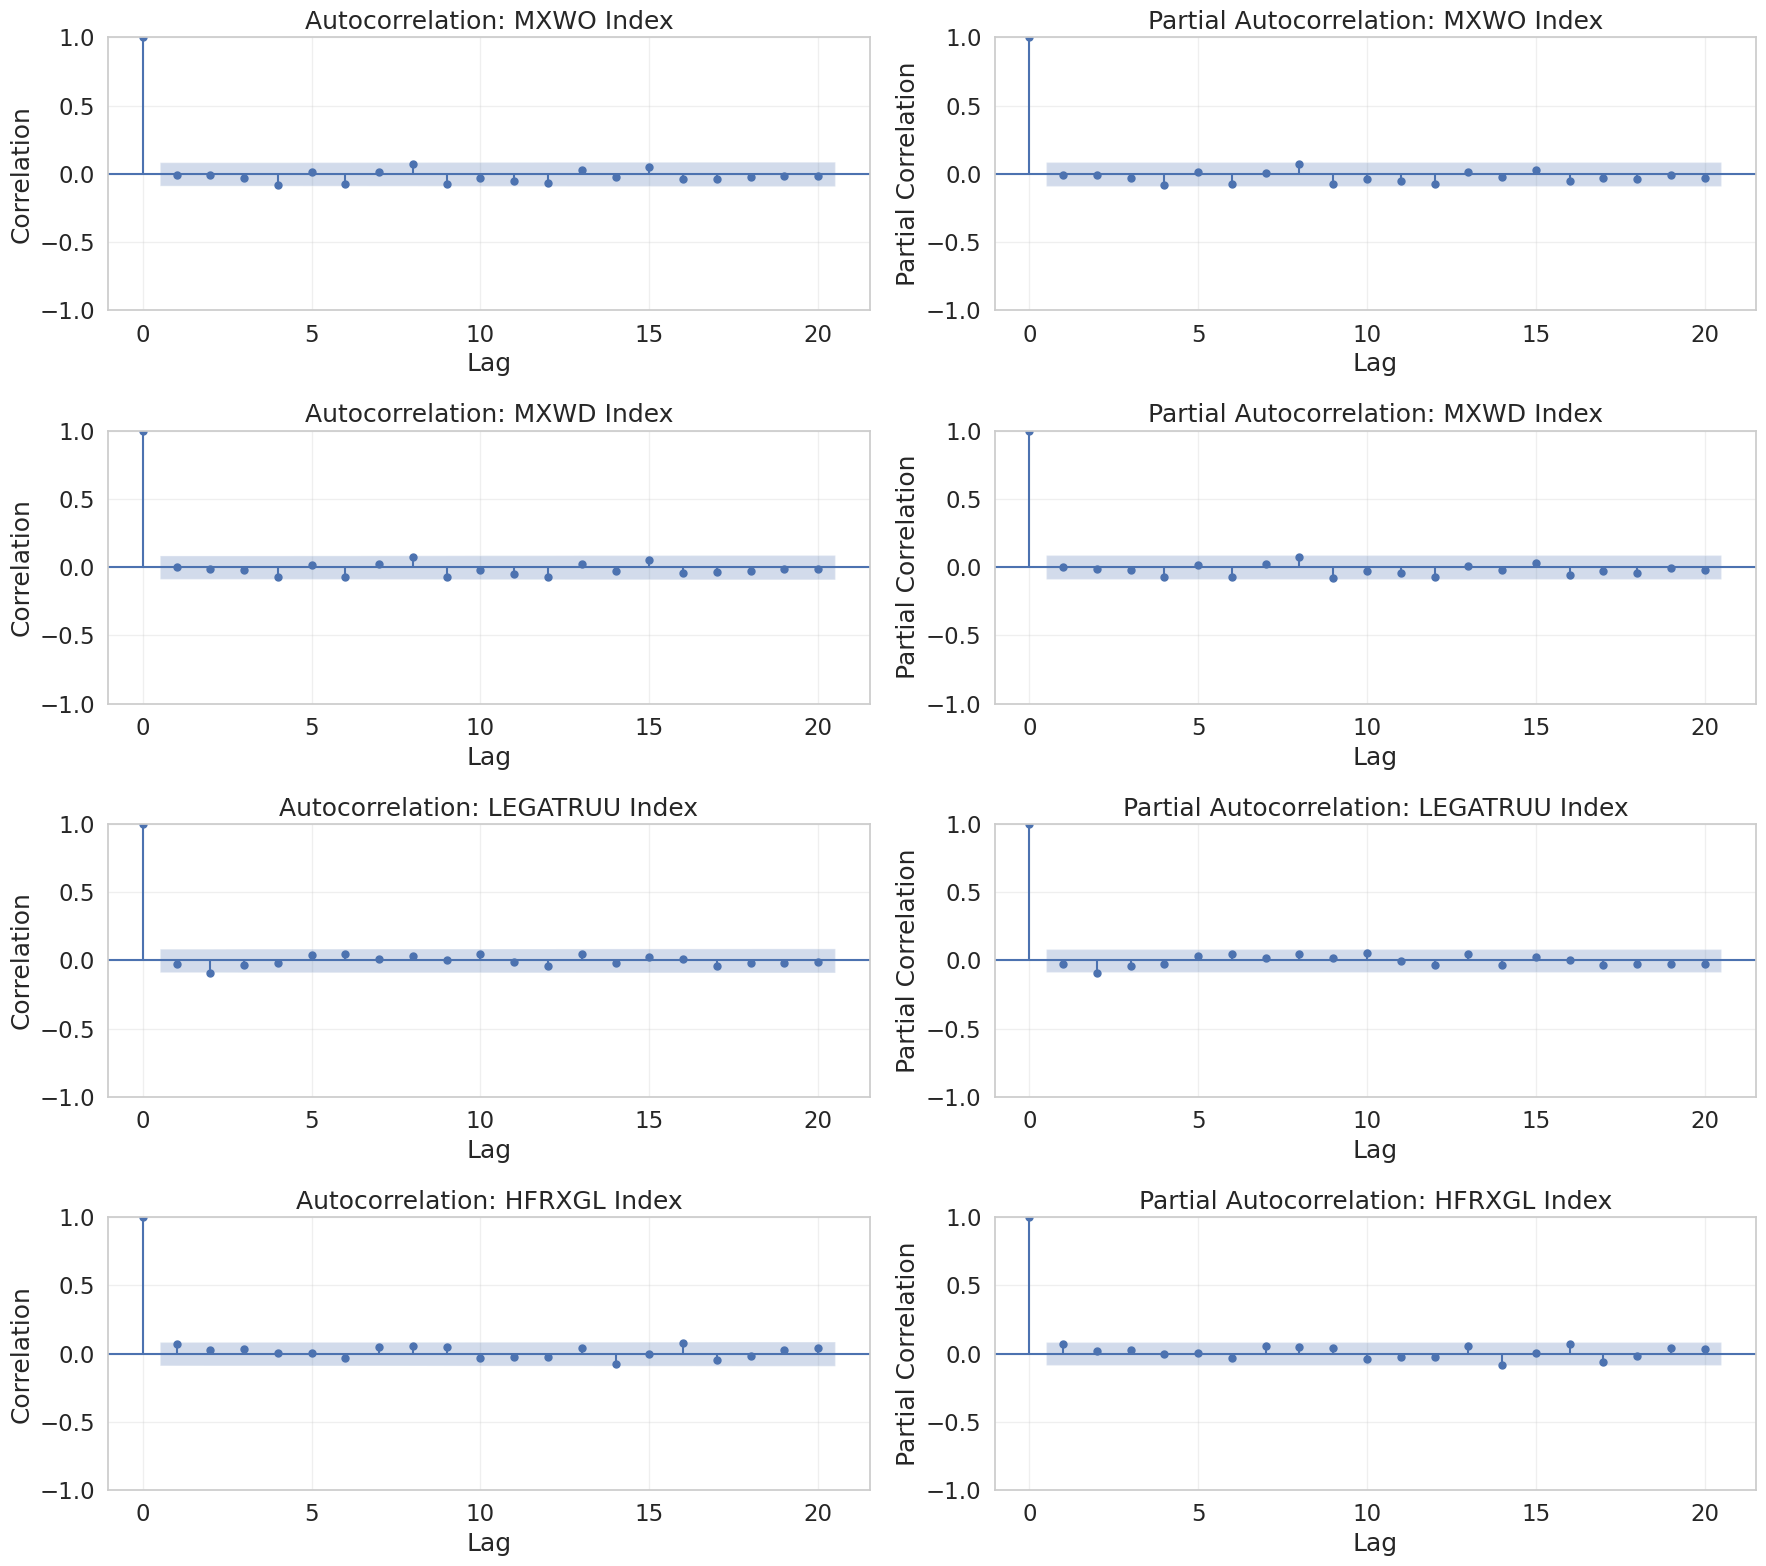

In [52]:
# Autocorrelation and Partial Autocorrelation analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define the maximum number of lags to analyze
max_lags = 20

# Create a figure for ACF and PACF plots
fig, axes = plt.subplots(len(target_indices), 2, figsize=(18, 4*len(target_indices)))

# For each target index
for i, idx in enumerate(target_indices):
    # Get returns data for this index
    returns_data = returns[idx].dropna()

    # Plot ACF (Autocorrelation Function)
    plot_acf(returns_data,
             lags=max_lags,
             ax=axes[i, 0],
             title=f'Autocorrelation: {idx}',
             alpha=0.05)  # 95% confidence intervals

    axes[i, 0].set_xlabel('Lag')
    axes[i, 0].set_ylabel('Correlation')
    axes[i, 0].grid(True, alpha=0.3)

    # Plot PACF (Partial Autocorrelation Function)
    plot_pacf(returns_data,
              lags=max_lags,
              ax=axes[i, 1],
              title=f'Partial Autocorrelation: {idx}',
              alpha=0.05)  # 95% confidence intervals

    axes[i, 1].set_xlabel('Lag')
    axes[i, 1].set_ylabel('Partial Correlation')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Some **statistical tests for Autocorrelation**:
Let's perform formal statistical tests to check for autocorrelation in our return series.

In [53]:
# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box test for Autocorrelation (H0: No autocorrelation)")
for idx in target_indices:
    # Get returns data for this index
    returns_data = returns[idx].dropna()

    # Perform Ljung-Box test for different lags
    lb_test = acorr_ljungbox(returns_data, lags=[5, 10, 15, 20])

    print(f"\n{idx}:")
    print(f"  Lag 5:  Test Statistic = {lb_test.iloc[0, 0]:.4f}, p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"  Lag 10: Test Statistic = {lb_test.iloc[1, 0]:.4f}, p-value = {lb_test.iloc[1, 1]:.4f}")
    print(f"  Lag 15: Test Statistic = {lb_test.iloc[2, 0]:.4f}, p-value = {lb_test.iloc[2, 1]:.4f}")
    print(f"  Lag 20: Test Statistic = {lb_test.iloc[3, 0]:.4f}, p-value = {lb_test.iloc[3, 1]:.4f}")



Ljung-Box test for Autocorrelation (H0: No autocorrelation)

MXWO Index:
  Lag 5:  Test Statistic = 3.8664, p-value = 0.5688
  Lag 10: Test Statistic = 12.7462, p-value = 0.2382
  Lag 15: Test Statistic = 18.9557, p-value = 0.2157
  Lag 20: Test Statistic = 20.9004, p-value = 0.4030

MXWD Index:
  Lag 5:  Test Statistic = 3.2022, p-value = 0.6688
  Lag 10: Test Statistic = 12.5090, p-value = 0.2524
  Lag 15: Test Statistic = 18.6170, p-value = 0.2316
  Lag 20: Test Statistic = 20.8719, p-value = 0.4047

LEGATRUU Index:
  Lag 5:  Test Statistic = 5.9058, p-value = 0.3155
  Lag 10: Test Statistic = 9.0688, p-value = 0.5256
  Lag 15: Test Statistic = 11.9186, p-value = 0.6852
  Lag 20: Test Statistic = 13.4787, p-value = 0.8559

HFRXGL Index:
  Lag 5:  Test Statistic = 3.2746, p-value = 0.6577
  Lag 10: Test Statistic = 8.1890, p-value = 0.6104
  Lag 15: Test Statistic = 13.0976, p-value = 0.5948
  Lag 20: Test Statistic = 19.5305, p-value = 0.4876


<br>

**Volatility Clustering Analysis**: Financial returns often exhibit volatility clustering - periods of high volatility tend to be followed by similar high volatility periods. We'll examine this phenomenon: as before, it is possible to take this into account in the modelling, and in any case it is better to know what the situation is.

<br>

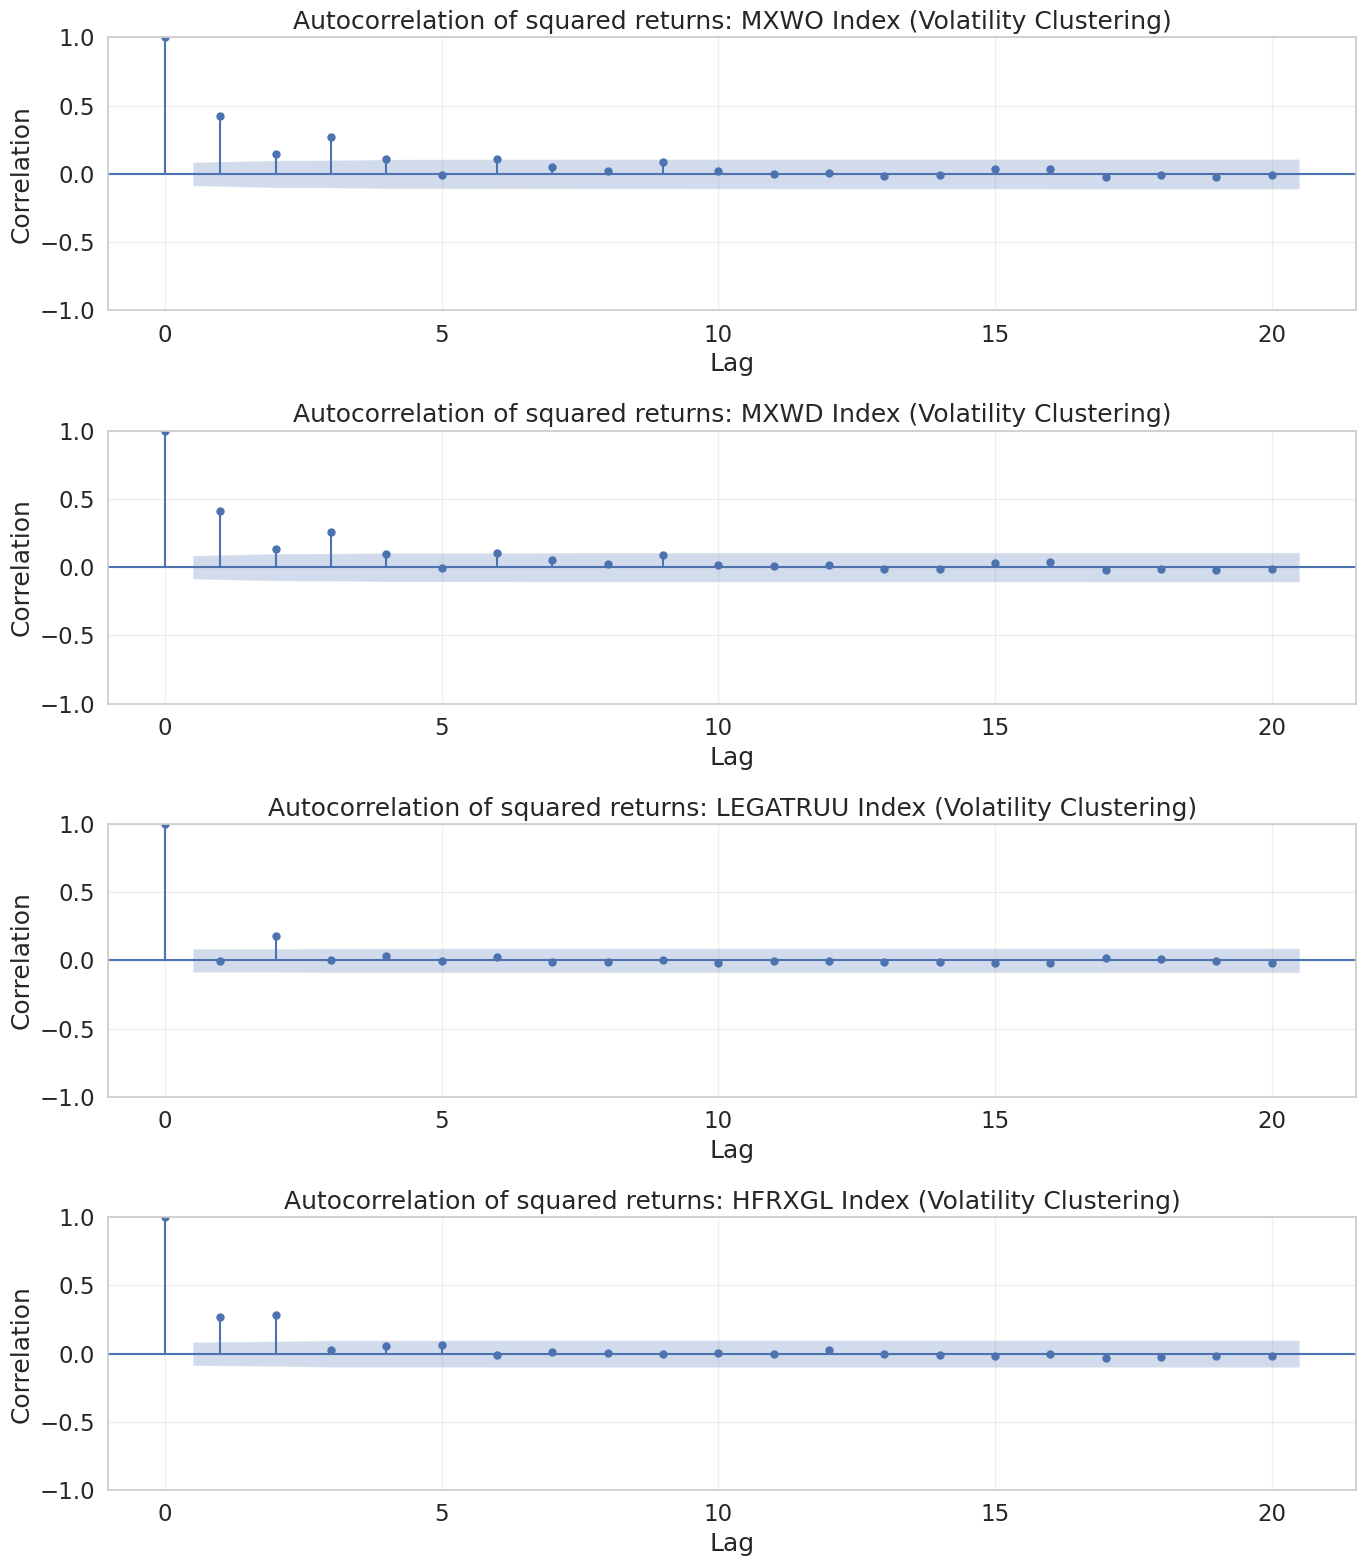

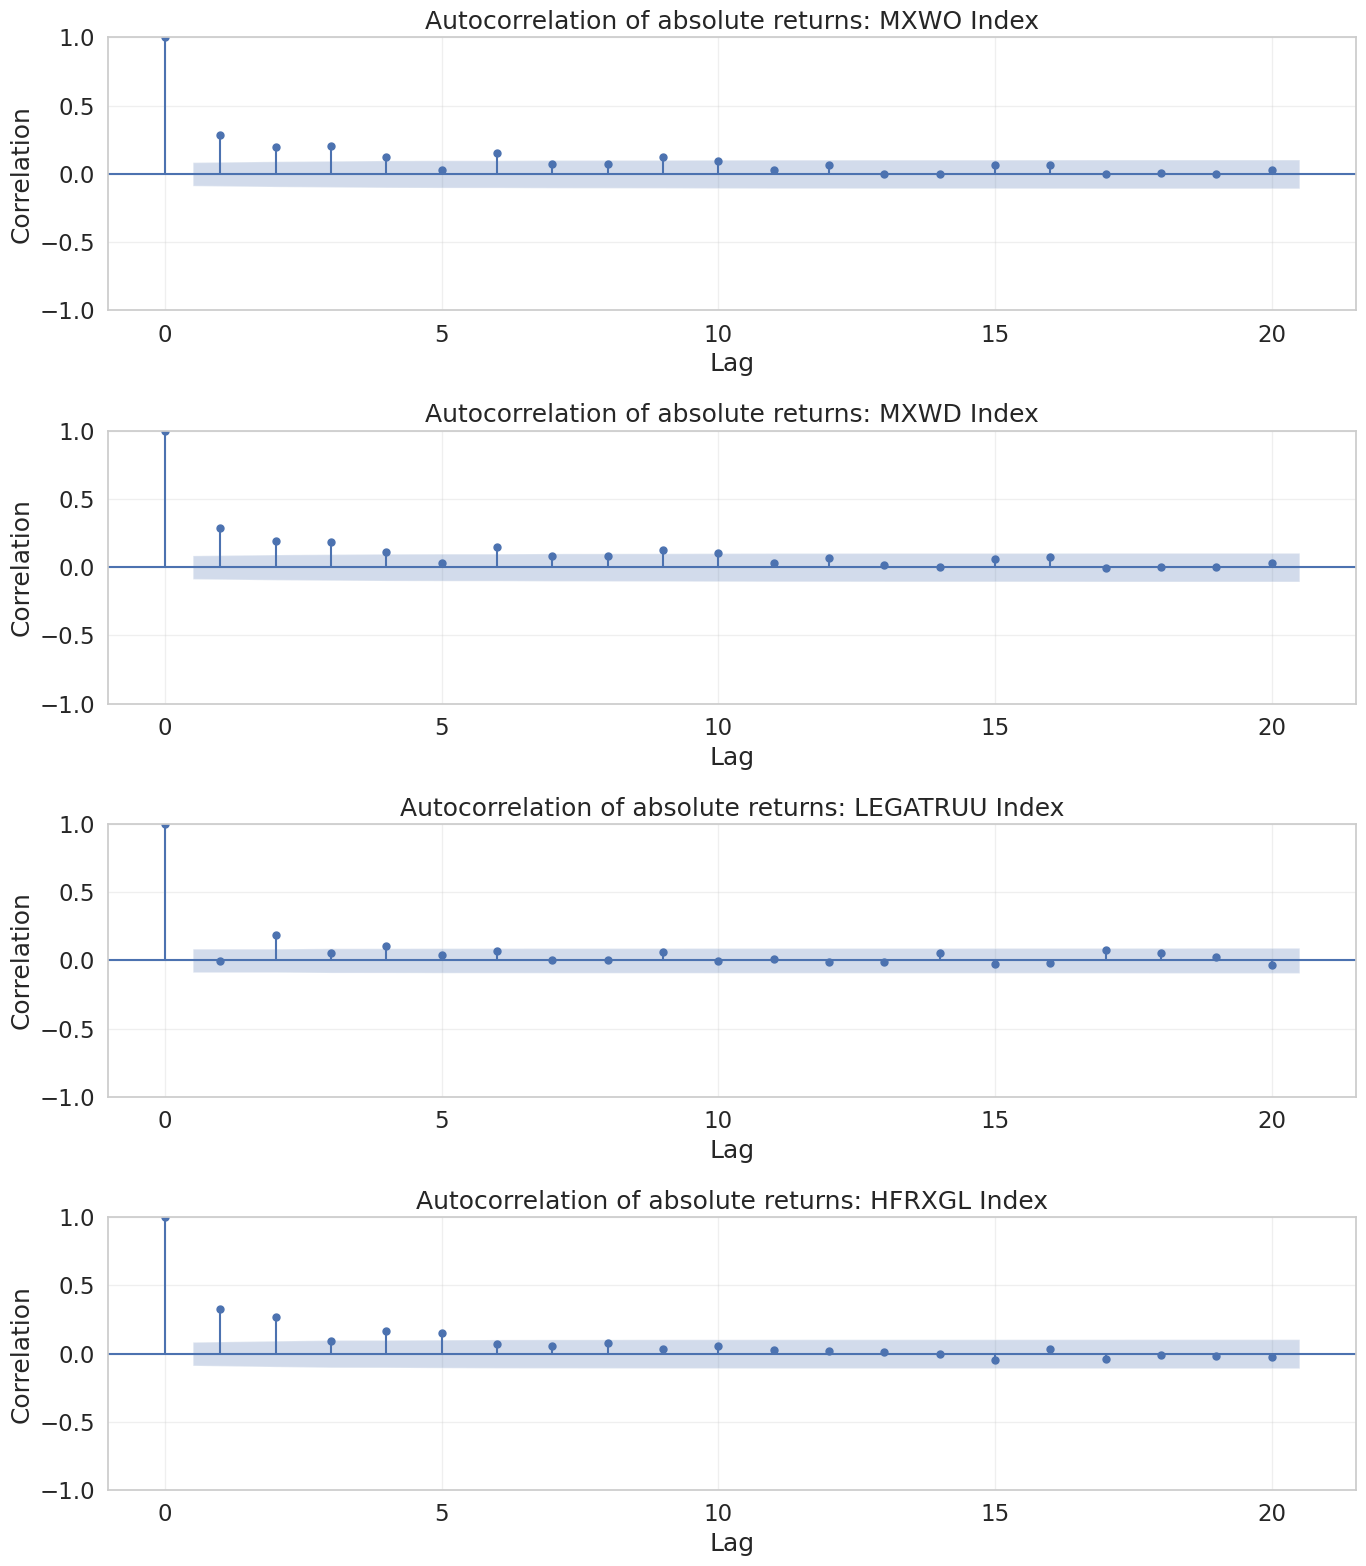

In [55]:
# Create a figure for squared returns ACF (volatility clustering)
fig, axes = plt.subplots(len(target_indices), 1, figsize=(14, 4*len(target_indices)))

# For each target index
for i, idx in enumerate(target_indices):
    # Get squared returns data for this index (for volatility clustering, ie GARC-like situations)
    squared_returns = returns[idx].dropna() ** 2

    # Plot ACF of squared returns
    plot_acf(squared_returns,
             lags=max_lags,
             ax=axes[i] if len(target_indices) > 1 else axes,
             title=f'Autocorrelation of squared returns: {idx} (Volatility Clustering)',
             alpha=0.05)  # 95% confidence intervals

    if len(target_indices) > 1:
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Correlation')
        axes[i].grid(True, alpha=0.3)
    else:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a figure for absolute returns ACF (another measure of volatility clustering)
fig, axes = plt.subplots(len(target_indices), 1, figsize=(14, 4*len(target_indices)))

# For each target index
for i, idx in enumerate(target_indices):
    # Get absolute returns data for this index
    abs_returns = abs(returns[idx].dropna())

    # Plot ACF of absolute returns
    plot_acf(abs_returns,
             lags=max_lags,
             ax=axes[i] if len(target_indices) > 1 else axes,
             title=f'Autocorrelation of absolute returns: {idx}',
             alpha=0.05)  # 95% confidence intervals

    if len(target_indices) > 1:
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Correlation')
        axes[i].grid(True, alpha=0.3)
    else:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<br>

Now let's analyze our constructed target index, the Monster Index, and Futures contracts that are candidates to replicate it in more detail to understand its characteristics before attempting replication.

<br>

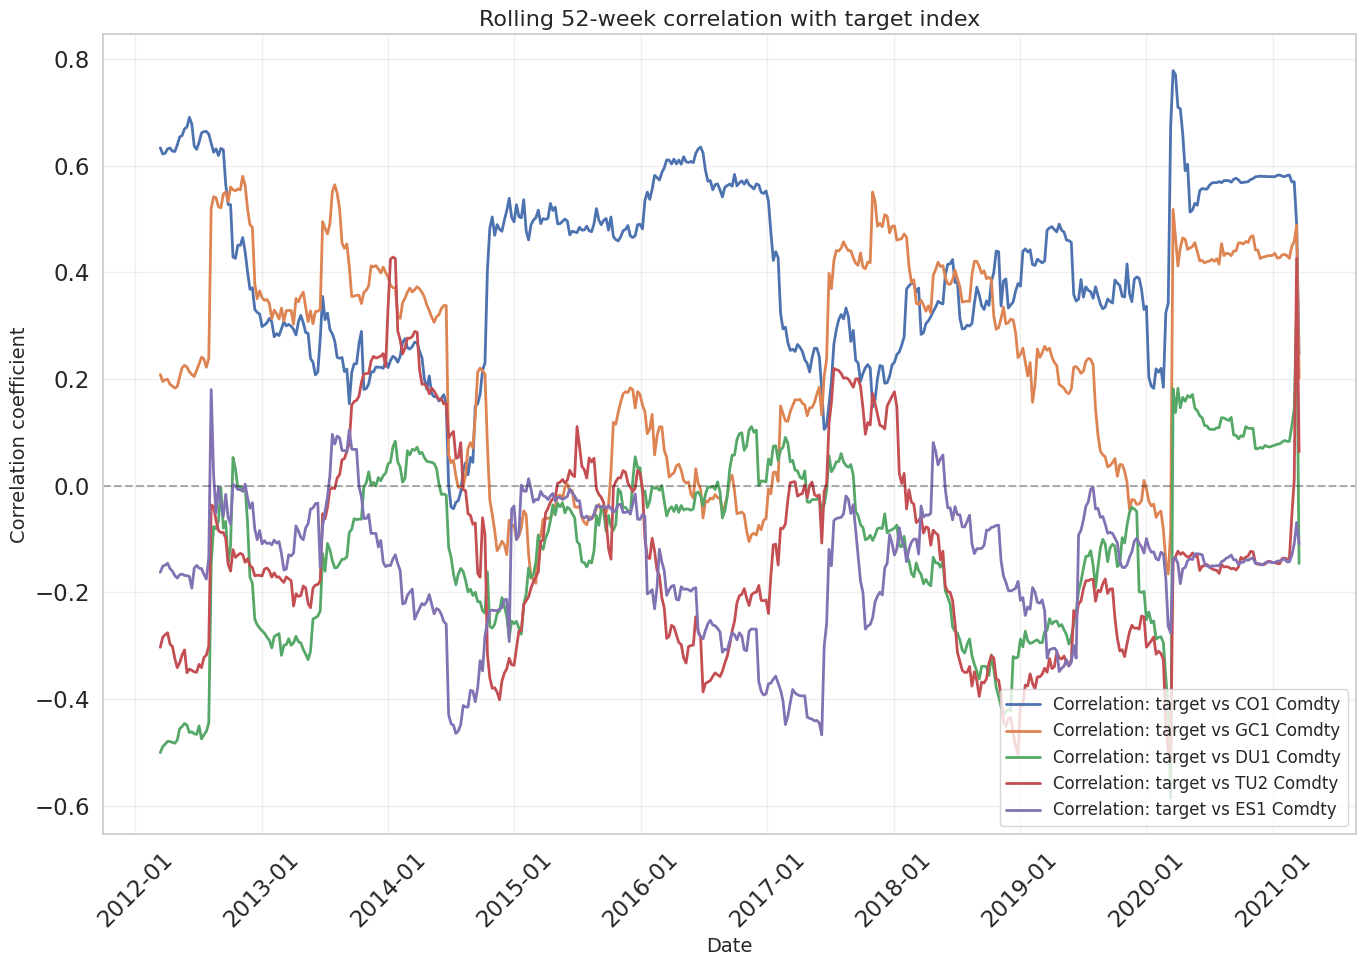

In [57]:
# Plot rolling correlations between target index and Futures contracts
rolling_window = 52  # 52 weeks ≈ 1 year
plt.figure(figsize=(14, 10))

# Select top 5 futures by correlation (absolute value)
top_futures = correlations.index[:5].tolist()

for contract in top_futures:
    # Calculate rolling correlation
    combined_df = pd.DataFrame({
        'Target': target_returns_aligned,  # Fixed variable name
        'Future': futures_returns[contract]
    })
    rolling_corr = combined_df['Target'].rolling(rolling_window).corr(combined_df['Future'])

    # Plot
    plt.plot(rolling_corr.index, rolling_corr, linewidth=2,
             label=f"Correlation: target vs {contract}")

plt.title(f'Rolling {rolling_window}-week correlation with target index', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Correlation coefficient', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


If you look at the time series and their correlations with the target, they have heterogeneous paths, so it's intuitive that they can be of help, if we want to replicate complex assets, such as our "Monster Index".

In [58]:
# Calculate and display target index statistics
print("\nTarget index statistics:")
annual_factor = 52  # For weekly data

# Calculate statistics
mean_return = target_returns_aligned.mean() * annual_factor
volatility = target_returns_aligned.std() * np.sqrt(annual_factor)
sharpe_ratio = mean_return / volatility
cumulative_returns = (1 + target_returns_aligned).cumprod()
drawdowns = 1 - cumulative_returns / cumulative_returns.cummax()
max_drawdown = drawdowns.max()
skewness = target_returns_aligned.skew()
kurtosis = target_returns_aligned.kurtosis()

# Display statistics
stats_df = pd.DataFrame({
    'Statistic': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
                  'Max Drawdown', 'Skewness', 'Kurtosis'],
    'Value': [f"{mean_return*100:.2f}%",
              f"{volatility*100:.2f}%",
              f"{sharpe_ratio:.2f}",
              f"{max_drawdown*100:.2f}%",
              f"{skewness:.2f}",
              f"{kurtosis:.2f}"]
})

display(stats_df)

# Also calculate and display monthly returns statistics
if len(target_returns_aligned) >= 12:  # Ensure we have enough data
    # Resample to monthly returns using 'ME' (month end) frequency - more robust
    monthly_returns = target_returns_aligned.resample('ME').apply(
        lambda x: (1 + x).prod() - 1)

    # Calculate monthly statistics
    monthly_mean = monthly_returns.mean() * 12
    monthly_vol = monthly_returns.std() * np.sqrt(12)
    monthly_sharpe = monthly_mean / monthly_vol if monthly_vol > 0 else 0

    # Display monthly statistics
    print("\nMonthly return statistics:")
    monthly_stats = pd.DataFrame({
        'Statistic': ['Annualized return (monthly)',
                     'Annualized volatility (monthly)',
                     'Sharpe ratio (monthly)'],
        'Value': [f"{monthly_mean*100:.2f}%",
                 f"{monthly_vol*100:.2f}%",
                 f"{monthly_sharpe:.2f}"]
    })

    display(monthly_stats)



Target index statistics:


,Statistic,Value
0,Annualized return,3.65%
1,Annualized volatility,5.76%
2,Sharpe ratio,0.63
3,Max Drawdown,13.25%
4,Skewness,-2.48
5,Kurtosis,19.05



Monthly return statistics:


,Statistic,Value
0,Annualized return (monthly),3.71%
1,Annualized volatility (monthly),6.82%
2,Sharpe ratio (monthly),0.54


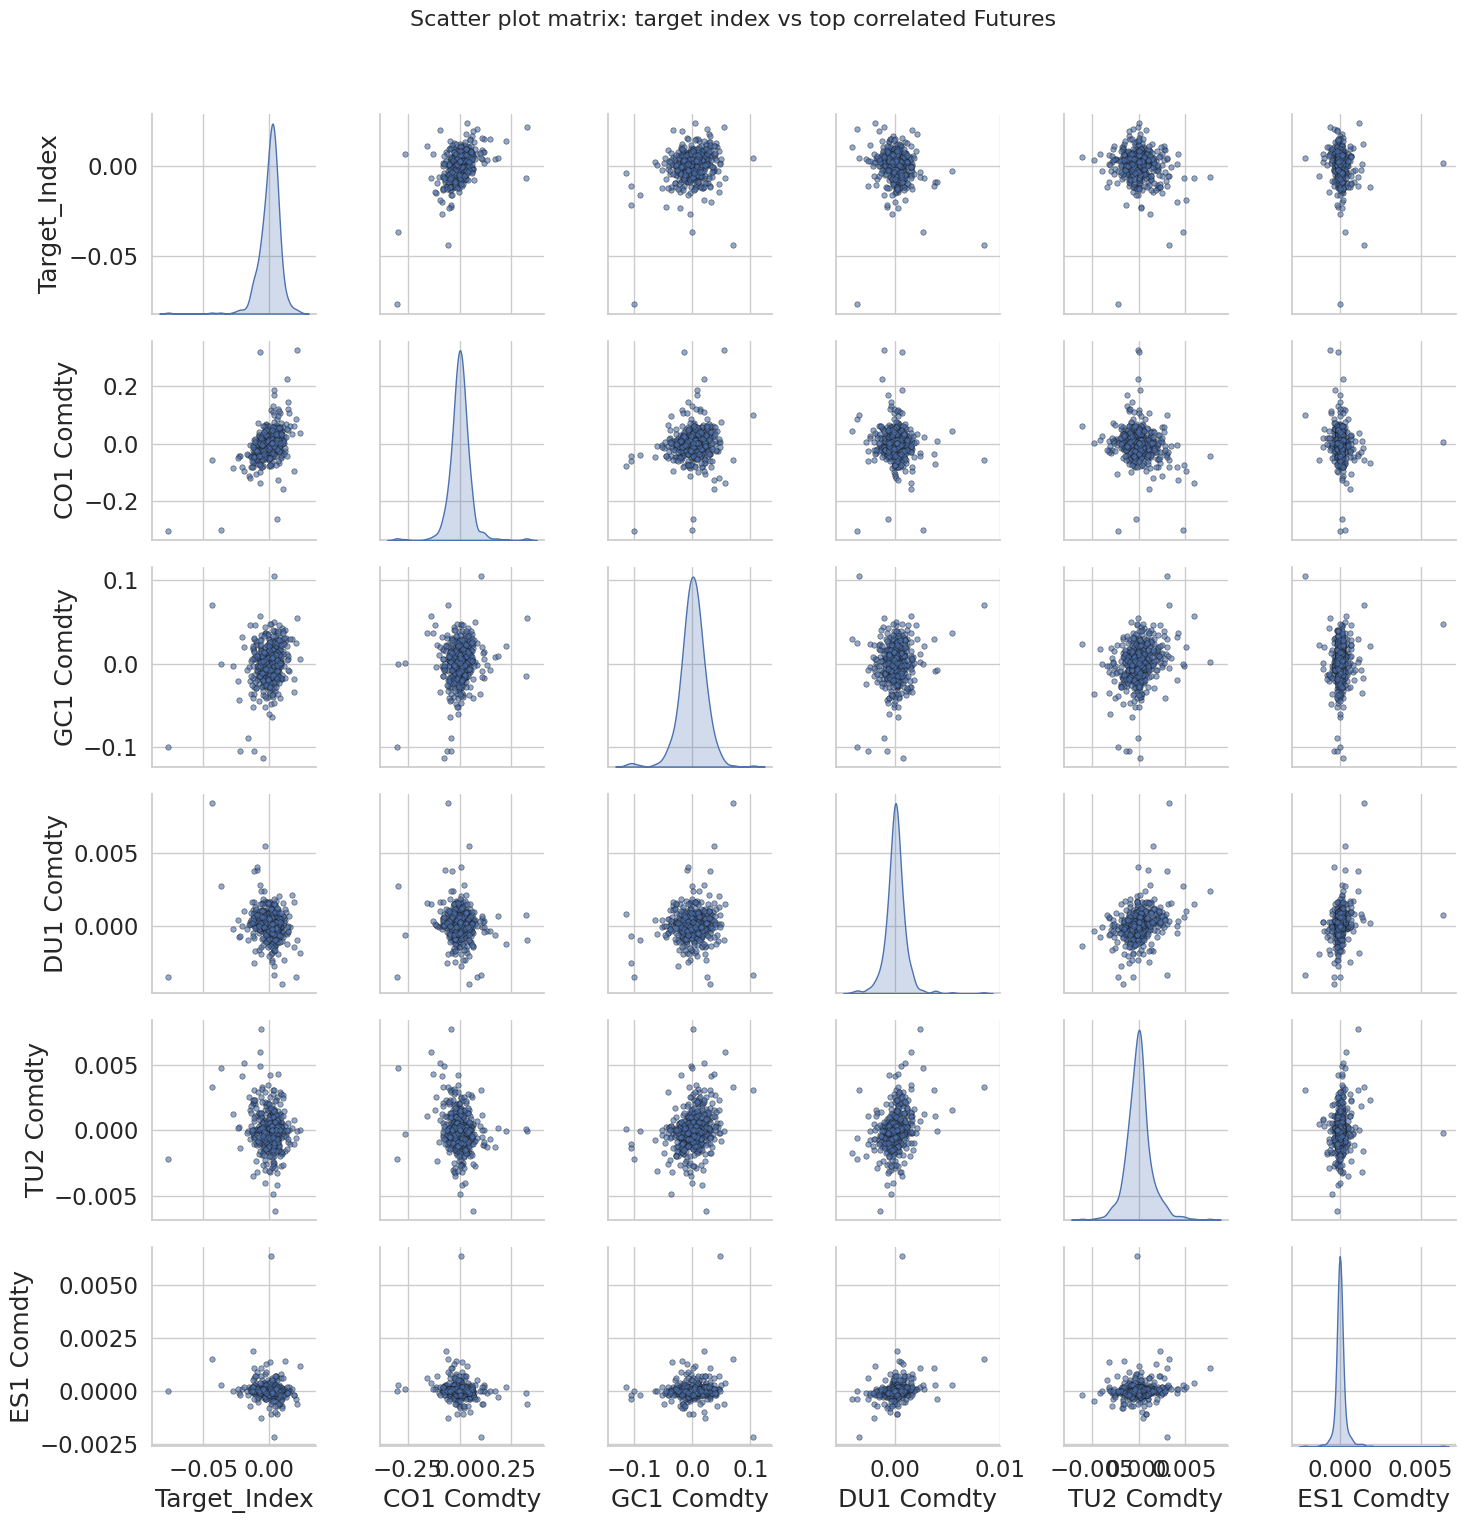

In [59]:
# Create a scatter plot matrix for the target index and top correlated futures
top_futures_plus_target = ['Target_Index'] + top_futures
scatter_data = pd.concat([target_returns_aligned.rename('Target_Index'),
                          futures_returns[top_futures]], axis=1)

# Create a pair plot
sns.pairplot(scatter_data, kind='scatter', diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 15, 'edgecolor': 'k', 'linewidth': 0.5})
plt.suptitle('Scatter plot matrix: target index vs top correlated Futures',
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Using linear models for portfolio replication?

In this setting, we are not just interested in predicting returns — we are building an **investment portfolio**, which has a specific structure:

### **A portfolio is a linear combination of assets**

Let’s recall that a financial portfolio is defined as a **linear combination** of assets (they can be non-linear, such as options and other derivatives, but a portfolio is always a linear combination of financial instruments):

$
r_p = \sum_{i=1}^n w_i \cdot r_i
$

where:
- $r_p$ is the portfolio return,
- $w_i$ are the portfolio weights,
- $r_i$ are the financial asset returns.

So when we try to **replicate** a black-box return series using observable asset returns, the most natural approach is to **model it as a linear regression**.

<br>

---

### 🎯 We care about the structure, not the forecast

In Machine Learning, models like:
- Gaussian Process Regression
- Neural Networks
- Random Forests

are great for **predictive accuracy**, but typically they **do not produce usable portfolio weights**.

They model $y = f(X)$ where $f$ is a complex, non-linear function. Even if you get a good forecast, you **cannot translate it into a portfolio**.

In contrast, **linear regression and its penalized variants like Ridge, Lasso, Elastic Net** give us:

$
y_t = X_t \cdot \beta + \varepsilon_t
$

where $beta$ are the **portfolio weights**. This makes them ideal for **replication tasks**, where we are interested in constructing a replicating portfolio, not  in predicting values.

<br>

### 🧩 From Regression Coefficients to Portfolio Weights

Once we fit a regression model, we **interpret the resulting coefficients as portfolio weights**.

### Why This Makes Sense

- The target variable (e.g., HFRX index returns or whatever) is modeled as a **linear combination** of asset returns.
- The fitted coefficients $beta_j$ represent the **contribution** of each asset to the replicated return.
- Therefore, we can treat them as **portfolio weights**.

$
\hat{r}_{\text{replica}} = \sum_j \beta_j \cdot r_j
$

---

#### Long and Short Positions

Because we are using **Futures contracts**, we can allow:
- **Positive weights** → long positions
- **Negative weights** → short positions

There is no need to constrain the model to long-only — the futures framework supports full long/short flexibility.

---

#### ⚠️ Risk Constraint: Monthly VaR

To control the portfolio's risk, we apply a **Value-at-Risk (VaR)** constraint (EU Law):
- **Horizon**: 1 month
- **Confidence level**: 99%
- **Maximum allowed VaR**: 20%

If the estimated VaR exceeds this threshold, or a lower prudential threshold, we **rescale the portfolio weights** to bring risk under control.

> This allows us to exploit long/short opportunities while maintaining a cap on downside risk.


<br>

---

<br>

**About splitting the data**

This is key. Since we are dealing with **time series**, a phenomenon that develops over time, with time dependencies (see above analysis of AC, PAC, etc), and must be dynamically tested, we slightly change the approach of creating and testing the model: the usual approach used with static or cross-sectional data doesn't make sense here.


With time series here we'll use a **standard backtest approach**:
* In time t we define a **rolling window of length K** used for training and possibly cross-validation.
* we will use our estimated model out-of-sample, on **unseen data**, in order to predict from t to t+Horizon (Horizon will be = 1 = 1 week here, but you can have longer horizons if you like).
* we will **roll forward the sample**, using this **step-by-step estimation/prediction approach**;
* we will judge the model on the prediction on unseen data - ie out-of-sample.


**Caution**: the backtest approach with financial data it is never sure: the financial market is constantly changing. Our model/any model can be meaningless if the world changes enough...

<br>

### HINTs
#### 🛠️ Start simple: linear regression (OLS)

As always, it's wise to begin with simple, transparent methods. Linear regression is:
- Quick
- Interpretable,
- Grounded in financial theory
- And it gives us the exact object we want: **weights**.

You can always try fancier models later — but for portfolio replication, linear models are a great starting point to understand.

<br>

Here in class we use **more recent generation regression models**, true workhorses of Machine Learning.



## 📉 Ridge, Lasso, and Elastic Net Regularization

When building linear models, we often want to **penalize large coefficients** to avoid overfitting and improve generalization. There are three main regularization techniques for this:

- **Ridge Regression** (L2 regularization)
- **Lasso Regression** (L1 regularization)
- **Elastic Net** (a hybrid of L1 and L2)

---

### Lasso Regression

Lasso regression (Least Absolute Shrinkage and Selection Operator) adds a **penalty on the absolute value** of the coefficients:

$
\min_{\beta} \left\{ \| y - X\beta \|^2 + \lambda \sum_j |\beta_j| \right\}
$

Key properties:
- Performs **feature selection**: it can shrink some coefficients exactly to zero.
- Helps when the number of features is large, or when features are **highly correlated**.
- Can produce **simpler models**, which is useful in portfolio replication — fewer trades, less noise.
- Lasso is especially effective when only a **small subset** of the features are truly important. Which can be your case...

---

### Ridge Regression

Ridge regression adds a **penalty on the square of the coefficients**:

$
\min_{\beta} \left\{ \| y - X\beta \|^2 + \lambda \sum_j \beta_j^2 \right\}
$

Key properties:
- Tends to **shrink all coefficients**, but none exactly to zero.
- **Keeps all features in the model** — good if the signal is spread across many inputs (which makes sense in portfolio contruction).
- Helps deal with **multicollinearity** (predictors that are linearly correlated).
- Often results in **smoother models**, but with less interpretability.


---

### Elastic Net

Elastic Net is a **blend of Ridge and Lasso**, combining their penalties:

$
\min_{\beta} \left\{ \| y - X\beta \|^2 + \lambda \left( \alpha \sum_j |\beta_j| + (1 - \alpha) \sum_j \beta_j^2 \right) \right\}
$

- The hyperparameter \( \alpha \in (0,1] \) controls the mix:
  - $alpha = 1$: pure Lasso
  - $alpha \to 0$: approaches Ridge
- Useful when you have **many correlated predictors** (and you are undecided).
- Can outperform both Ridge and Lasso in certain real-world datasets.

> 🔗 [More on Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization)

---

### ⚙️ Hyperparameter Tuning

For all three methods, you need to choose:
- $lambda$: the **regularization strength**
- For Elastic Net: $alpha$: the **mixing parameter**

Best practice:
- Use **cross-validation** (e.g., 5-fold CV) to find the optimal $lambda$.
- Try a **grid search** on a range of $lambda$ values.
- For Elastic Net, you might also search over multiple values of $alpha$.

---

### 📌 Summary

| Method        | Penalty         | Allows zero coefficients? | Best use case                          |
|---------------|------------------|-------------------------|-----------------------------------------|
| **Ridge**     | $sum \beta_j^2$ | ❌                      | When all features are relevant          |
| **Lasso**     | $sum |\beta_j|$ | ✅                      | When few features are truly important   |
| **Elastic Net** | Mix of L1 & L2    | ✅                      | When features are correlated            |

---

<br>


I go straight for Elastic Net...

### Example with Elastic Net

We will use various values ​​for the hyperparameters.

In [60]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from itertools import product

# Ensure data is properly aligned
y = target_returns_aligned  # Target index returns
X = futures_returns.loc[y.index]  # Futures returns aligned with target

# Define hyperparameter grid - this is rough, on purpose: you can do better
l1_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # remember: 0.0 = Ridge, 1.0 = Lasso
rolling_windows = [52, 104, 156]  # in weeks (1Y, 2Y, 3Y)
alphas = [0.0001, 0.001, 0.01]  # Regularization strength

# VaR parameters
var_confidence = 0.01  # 1% VaR
var_horizon = 4  # 4 weeks (1 month)
max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)

# Convert to numpy arrays for easier indexing
X_values = X.values
y_values = y.values
dates_array = X.index.to_numpy()

# Suppress boring warnings during the loop
import warnings
warnings.filterwarnings('ignore')

# Function to calculate VaR
def calculate_var(returns, confidence=0.01, horizon=4):
    """
    Calculate Value at Risk (VaR) using a simple Gaussian model (you can do better)

    Parameters:
    returns (array-like): Historical returns
    confidence (float): Confidence level (e.g., 0.01 for 1% VaR)
    horizon (int): Time horizon in weeks

    Returns:
    float: VaR as a positive number (loss)
    """
    # Calculate standard deviation of returns
    sigma = np.std(returns)

    # Calculate VaR using a Gaussian model
    # For a loss, we use the negative of the quantile
    # We use the negative of the quantile because VaR represents a loss
    # Note: this is just a a widespread and questionable practice (which I do not loke because it is ambiguous, there could be a positive VaR)
    z_score = stats.norm.ppf(confidence)

    # Scale to the desired time horizon
    var = -z_score * sigma * np.sqrt(horizon)

    return var



### Why normalize before Elastic Net regression?

You will notice in the following code that I used a normalization: when using **penalized regression models** such as Lasso or Elastic Net or whatever you like, it's standard practice to **normalize the input variables**.

You might think that this is a piece of crap. It actually makes a lot of sense to do this. Here's why.


#### The problem: unequal penalization

Regularization adds a penalty term to the loss function, ie:

$
\min_{\beta} \left\{ \| y - X\beta \|^2 + \alpha \left( \lambda \|\beta\|_1 + (1 - \lambda) \|\beta\|_2^2 \right) \right\}
$

If the columns of $X$ (our input features, e.g., returns of futures contracts) have **different scales**, then the penalty will **affect them unequally**. More volatile instruments will receive **higher penalties**, just because of their unit of measurement. This distorts the model.

---

#### Solution: Normalize $X$

We normalize each feature (e.g., via MinMax or Z-score scaling) to bring them to a comparable range.

This makes the penalty fair and allows Elastic Net to **select variables and assign weights** based on their **predictive power**, not their scale.

---

### What about the target $y$?

We also normalize $y$, the target time series (e.g., Monster Index returns), to ensure the regression works properly in the normalized space.

However, we do **not use predictions in the normalized space**. After the model is trained, we:

1. **Extract the coefficients** in the normalized space: $beta^{\text{norm}}$;
2. **Rescale them** back to the original units by dividing by the feature scaling factors:

$
\beta^{\text{original}}_j = \frac{\beta^{\text{norm}}_j}{s_j}
$

where $s_j$ is the scaling factor of feature $j$.

<br>

---

<br>


#### Why this is acceptable

In this application, we are not looking for interpretable regression coefficients — we want a **replicating portfolio**. The final weights must be in **original units** so we can compute portfolio returns, exposures, Value-at-Risk, etc.

Normalizing and then rescaling allows us to:
- Train a more robust and regularized model
- Avoid scale-induced bias
- Operate in real-world financial units in the end.

---
<br>

#### 📌 Key takeaway about normalization in this case

> *We normalize to train better models, and rescale to make those models usable in the real world.*

This is a **well-established trick** in penalized regression, particularly when working with **financial time series** that vary widely in volatility and magnitude.

<br>

In [63]:
# Function to run a single configuration with normalized returns and proper VaR scaling
def run_elastic_net_normalized(l1_ratio, rolling_window, alpha):
    # Initialize arrays to store results
    weights_history = []  # Store weights over time
    replica_returns = []  # Store replica portfolio returns
    target_dates = []  # Store dates for plotting
    gross_exposures = []  # Store gross exposure over time
    var_values = []  # Store VaR values over time
    scaling_factors = []  # Store scaling factors applied

    # Loop through the data using a rolling window approach as explained before
    for i in range(len(X) - rolling_window - 1):
        # Define training window
        start_idx = i
        end_idx = i + rolling_window

        # Extract training data
        X_train = X_values[start_idx:end_idx]
        y_train = y_values[start_idx:end_idx]

        # Normalize the training data using MinMaxScaler
        scaler_X = MinMaxScaler()
        X_train_normalized = scaler_X.fit_transform(X_train)

        # Normalize target
        scaler_y = MinMaxScaler()
        y_train_normalized = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

        # Fit Elastic Net model with a given alpha
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            fit_intercept=False,
            max_iter=10000,
            tol=1e-4
        )

        model.fit(X_train_normalized, y_train_normalized)

        # Get the normalized weights
        normalized_weights = model.coef_

        # Calculate weights for original scale
        original_weights = normalized_weights / scaler_X.scale_

        # Default scaling factor
        scaling_factor = 1.0

        # If we have enough historical data, calculate VaR and scale if needed
        if len(replica_returns) >= 12:  # Need some history to calculate VaR...
            # Calculate historical replica returns using current weights
            historical_returns = []
            for j in range(max(0, len(replica_returns)-52), len(replica_returns)):
                # Get historical futures returns for this period
                hist_returns = X_values[end_idx-(len(replica_returns)-j)]
                # Calculate weighted return
                weighted_return = np.dot(hist_returns, original_weights)
                historical_returns.append(weighted_return)

            # Calculate VaR
            var = calculate_var(
                historical_returns,
                confidence=var_confidence,
                horizon=var_horizon
            )


            # Scale weights if VaR exceeds threshold
            if var > max_var_threshold:
                scaling_factor = max_var_threshold / var
                original_weights = original_weights * scaling_factor

                # Recalculate VaR after scaling to verify
                scaled_historical_returns = [ret * scaling_factor for ret in historical_returns]
                scaled_var = calculate_var(
                    scaled_historical_returns,
                    confidence=var_confidence,
                    horizon=var_horizon
                )

                var = scaled_var  # Update VaR value after scaling

            var_values.append(var)
        else:
            var_values.append(np.nan)

        # Store scaling factor
        scaling_factors.append(scaling_factor)

        # Calculate gross exposure (sum of absolute weights) after scaling
        gross_exposure = np.sum(np.abs(original_weights))
        gross_exposures.append(gross_exposure)

        # Store the weights after scaling
        weights_history.append(original_weights)

        # Calculate replica return for the next period (t+1)
        next_returns = X_values[end_idx]  # This is t+1

        # Use scaled original weights with original returns
        replica_return = np.dot(next_returns, original_weights)

        replica_returns.append(replica_return)

        # Store the date for t+1
        target_dates.append(dates_array[end_idx])

    # Convert results to pandas series for easier analysis
    replica_returns_series = pd.Series(replica_returns, index=target_dates)

    # Calculate cumulative returns for both target and replica
    aligned_target = y.loc[replica_returns_series.index]
    cumulative_target = (1 + aligned_target).cumprod()
    cumulative_replica = (1 + replica_returns_series).cumprod()

    # Calculate performance metrics
    replica_mean_return = replica_returns_series.mean() * 52  # annualized
    target_mean_return = aligned_target.mean() * 52  # annualized

    replica_vol = replica_returns_series.std() * np.sqrt(52)  # annualized
    target_vol = aligned_target.std() * np.sqrt(52)  # annualized

    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else 0
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else 0

    # Calculate tracking error
    tracking_error = (replica_returns_series - aligned_target).std() * np.sqrt(52)
    information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else 0

    # Calculate drawdowns
    replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()
    target_drawdown = 1 - cumulative_target / cumulative_target.cummax()

    # Calculate correlation
    correlation = replica_returns_series.corr(aligned_target)

    # Calculate average gross exposure
    avg_gross_exposure = np.mean(gross_exposures)

    # Calculate average VaR (excluding NaN values)
    avg_var = np.nanmean(var_values)

    # Return all metrics
    return {
        'l1_ratio': l1_ratio,
        'rolling_window': rolling_window,
        'alpha': alpha,
        'replica_return': replica_mean_return,
        'target_return': target_mean_return,
        'replica_vol': replica_vol,
        'target_vol': target_vol,
        'replica_sharpe': replica_sharpe,
        'target_sharpe': target_sharpe,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'correlation': correlation,
        'max_drawdown': replica_drawdown.max(),
        'avg_gross_exposure': avg_gross_exposure,
        'avg_var': avg_var,
        'replica_returns': replica_returns_series,
        'aligned_target': aligned_target,
        'cumulative_replica': cumulative_replica,
        'cumulative_target': cumulative_target,
        'gross_exposures': gross_exposures,
        'var_values': var_values,
        'scaling_factors': scaling_factors,
        'weights_history': weights_history
    }

<br>

Now let's run the model with various values ​​for the hyperparameters.

<br>

In [65]:
# Run all combinations with normalized returns
results_normalized = []

for l1_ratio, rolling_window, alpha in product(l1_ratios, rolling_windows, alphas):
    result = run_elastic_net_normalized(l1_ratio, rolling_window, alpha)
    results_normalized.append(result)

# Convert results to DataFrame for easier analysis
results_df_normalized = pd.DataFrame(results_normalized)

# Sort by information ratio (higher is better) - our primary objective
sorted_results_normalized = results_df_normalized.sort_values(by='information_ratio', ascending=False)

# Display top 10 configurations by information ratio
print("\nTop 10 configurations by information ratio (normalized returns):")
display(sorted_results_normalized[['l1_ratio', 'rolling_window', 'alpha', 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(10))

# Get the best configuration by information ratio
best_config_normalized = sorted_results_normalized.iloc[0]
print(f"\nBest configuration by information ratio (normalized returns): l1_ratio={best_config_normalized['l1_ratio']}, "
      f"rolling_window={best_config_normalized['rolling_window']}, alpha={best_config_normalized['alpha']}")



Running all combinations with normalized returns...

Top 10 configurations by information ratio (normalized returns):


,l1_ratio,rolling_window,alpha,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
8,0.0,156,0.010,0.005002,0.264466,0.131079,0.268477,0.347026,0.054782
11,0.2,52,0.010,-0.060154,0.199663,0.112728,0.306924,0.133790,0.044158
29,0.6,52,0.010,-0.076615,0.232883,0.110537,0.292798,0.141574,0.035961
38,0.8,52,0.010,-0.083727,0.235301,0.109814,0.287953,0.142779,0.034109
20,0.4,52,0.010,-0.178168,0.221197,0.111189,0.189271,0.138136,0.039606
2,0.0,52,0.010,-0.179544,0.176554,0.123444,0.152387,0.136366,0.050318
47,1.0,52,0.010,-0.208180,0.257450,0.106238,0.173641,0.142628,0.033367
46,1.0,52,0.001,-0.215740,0.200736,0.120271,0.123168,0.142870,0.047605
37,0.8,52,0.001,-0.221525,0.197498,0.120443,0.116984,0.143146,0.048179
28,0.6,52,0.001,-0.232384,0.194753,0.120606,0.105624,0.144142,0.049314



Best configuration by information ratio (normalized returns): l1_ratio=0.0, rolling_window=156, alpha=0.01



Detailed metrics for the best configuration (normalized returns):


,Metric,Target,Replica
0,Annualized return,3.53%,3.60%
1,Annualized volatility,5.74%,13.40%
2,Sharpe ratio,0.62,0.27
3,Max Drawdown,27.24%,27.24%
4,Tracking Error,N/A,13.11%
5,Information ratio,N/A,0.01
6,Correlation,N/A,0.2645
7,Average gross exposure,N/A,0.3470
8,"Average VaR (1%, 1M)",N/A,5.48%


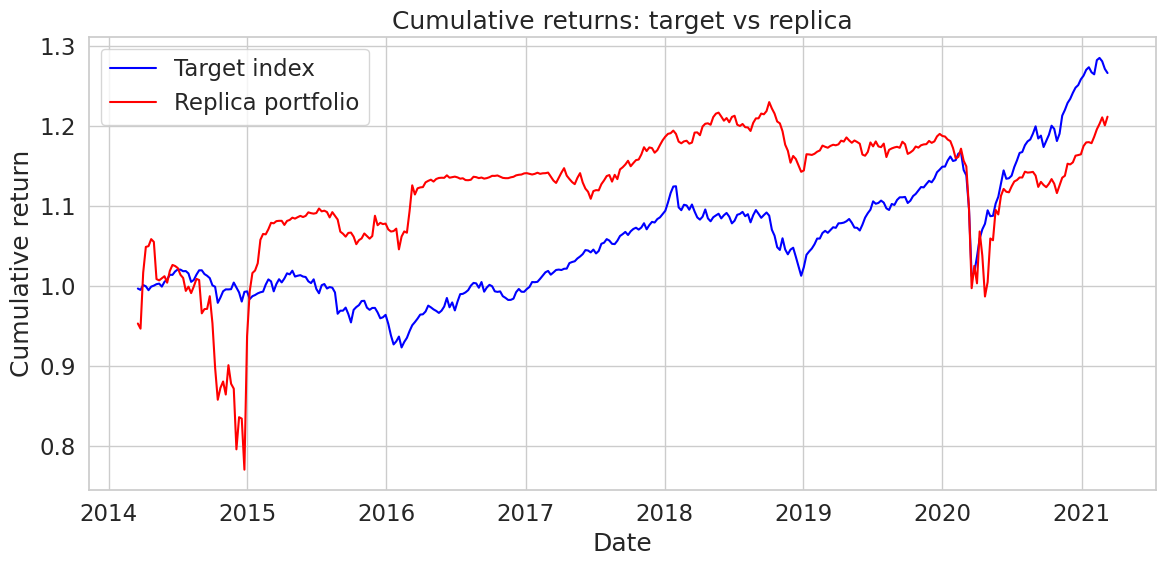

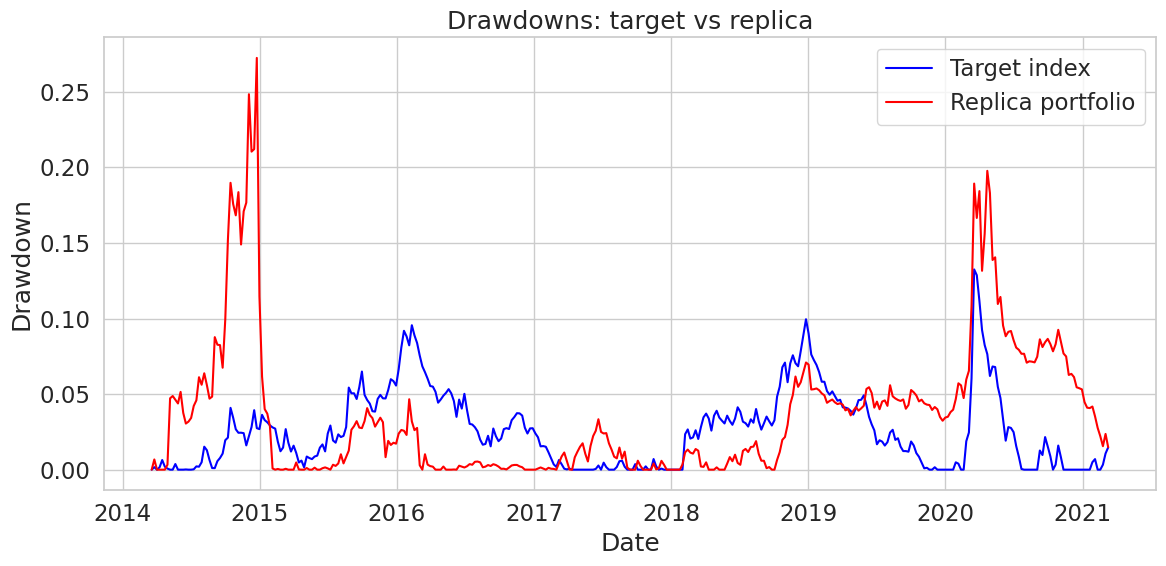

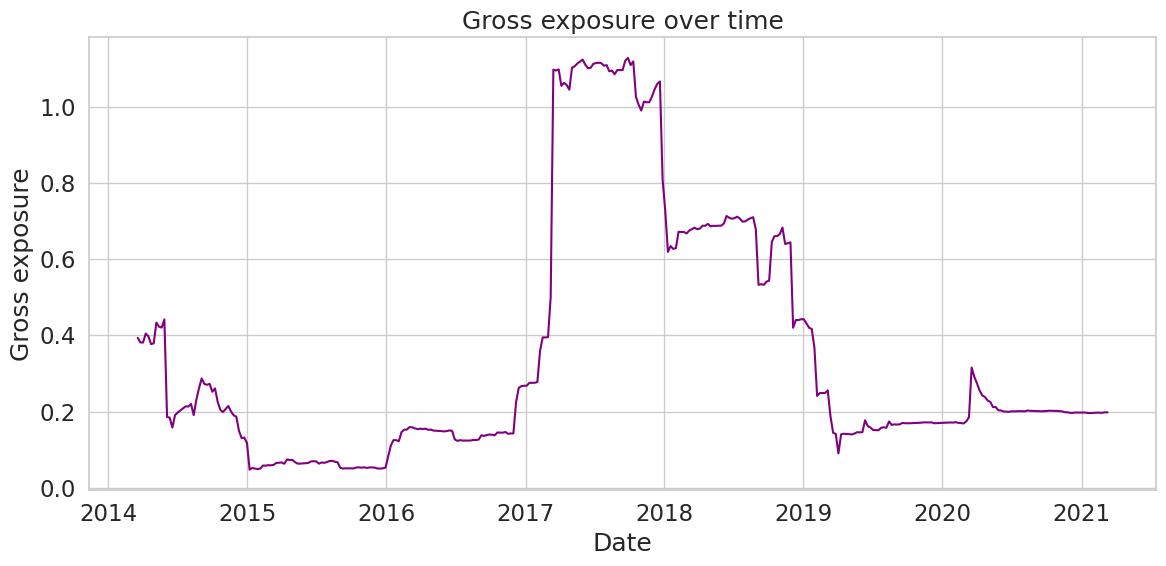

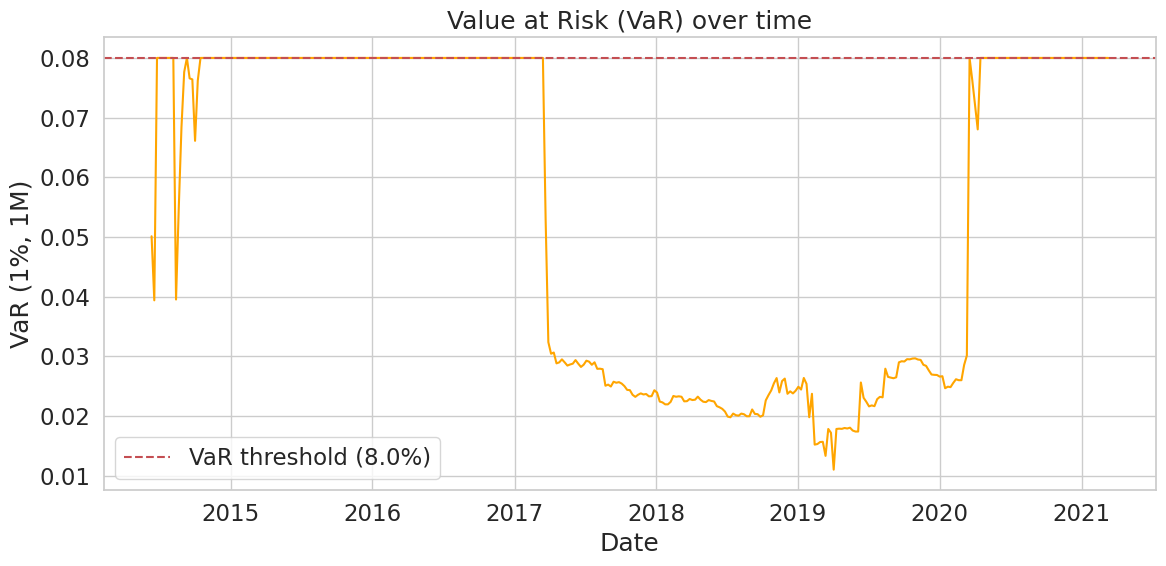

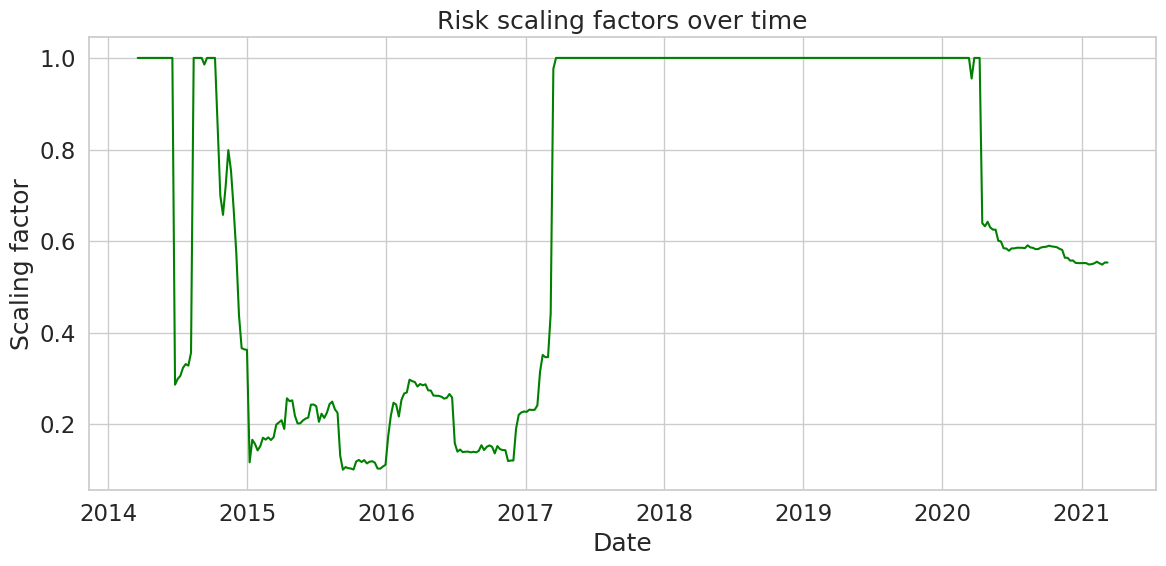

In [66]:
# Create detailed metrics table for the best configuration
metrics_normalized = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized['target_return']*100:.2f}%",
               f"{best_config_normalized['target_vol']*100:.2f}%",
               f"{best_config_normalized['target_sharpe']:.2f}",
               f"{best_config_normalized['max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized['replica_return']*100:.2f}%",
                f"{best_config_normalized['replica_vol']*100:.2f}%",
                f"{best_config_normalized['replica_sharpe']:.2f}",
                f"{best_config_normalized['max_drawdown']*100:.2f}%",
                f"{best_config_normalized['tracking_error']*100:.2f}%",
                f"{best_config_normalized['information_ratio']:.2f}",
                f"{best_config_normalized['correlation']:.4f}",
                f"{best_config_normalized['avg_gross_exposure']:.4f}",
                f"{best_config_normalized['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(best_config_normalized['cumulative_target'], label='Target index', color='blue')
plt.plot(best_config_normalized['cumulative_replica'], label='Replica portfolio', color='red')
plt.title('Cumulative returns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot drawdowns
plt.figure(figsize=(12, 6))
target_drawdown = 1 - best_config_normalized['cumulative_target'] / best_config_normalized['cumulative_target'].cummax()
replica_drawdown = 1 - best_config_normalized['cumulative_replica'] / best_config_normalized['cumulative_replica'].cummax()
plt.plot(target_drawdown, label='Target index', color='blue')
plt.plot(replica_drawdown, label='Replica portfolio', color='red')
plt.title('Drawdowns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot gross exposure over time
plt.figure(figsize=(12, 6))
gross_exposure_series = pd.Series(best_config_normalized['gross_exposures'], index=best_config_normalized['replica_returns'].index)
plt.plot(gross_exposure_series, color='purple')
plt.title('Gross exposure over time')
plt.xlabel('Date')
plt.ylabel('Gross exposure')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot VaR over time
plt.figure(figsize=(12, 6))
var_series = pd.Series(best_config_normalized['var_values'], index=best_config_normalized['replica_returns'].index)
plt.plot(var_series, color='orange')
plt.axhline(y=max_var_threshold, color='r', linestyle='--', label=f'VaR threshold ({max_var_threshold*100}%)')
plt.title('Value at Risk (VaR) over time')
plt.xlabel('Date')
plt.ylabel('VaR (1%, 1M)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot scaling factors over time
plt.figure(figsize=(12, 6))
scaling_series = pd.Series(best_config_normalized['scaling_factors'], index=best_config_normalized['replica_returns'].index)
plt.plot(scaling_series, color='green')
plt.title('Risk scaling factors over time')
plt.xlabel('Date')
plt.ylabel('Scaling factor')
plt.grid(True)
plt.tight_layout()
plt.show()


### Key Performance metrics
**Volatility**  
The standard deviation of a portfolio's returns, annualized.  
It represents the total variability of the investment.

---

**Tracking Error Volatility**  
The standard deviation of the difference between the returns of a portfolio and its benchmark.  
It measures how closely the portfolio follows the benchmark.  

$
TE = \sqrt{ \text{Variance}(r_{\text{portfolio}} - r_{\text{benchmark}}) }
$

---

**Sharpe Ratio**  
A measure of risk-adjusted return. It compares the excess return of a portfolio to its volatility.  
$
\text{Sharpe Ratio} = \frac{E[r_{\text{portfolio}} - r_f]}{\sigma_{\text{portfolio}}}
$
In practice, we often use 0% as the risk-free rate $r_f$ for short horizons.

---

**Max Drawdown**  
The maximum observed loss from a peak to a trough before a new peak is reached.  
It measures the worst-case decline in portfolio value over a given period.

---

**Gross Exposure**  
The sum of the absolute values of all portfolio weights.  
It indicates the total level of capital deployed, including both long and short positions.  
$
\text{Gross Exposure} = \sum_j |\text{weight}_j|
$

A gross exposure greater than 100% implies leverage. In EU maximum leverage can be 200%, or an amount such that the VaR(1%, 1 month)<20%.



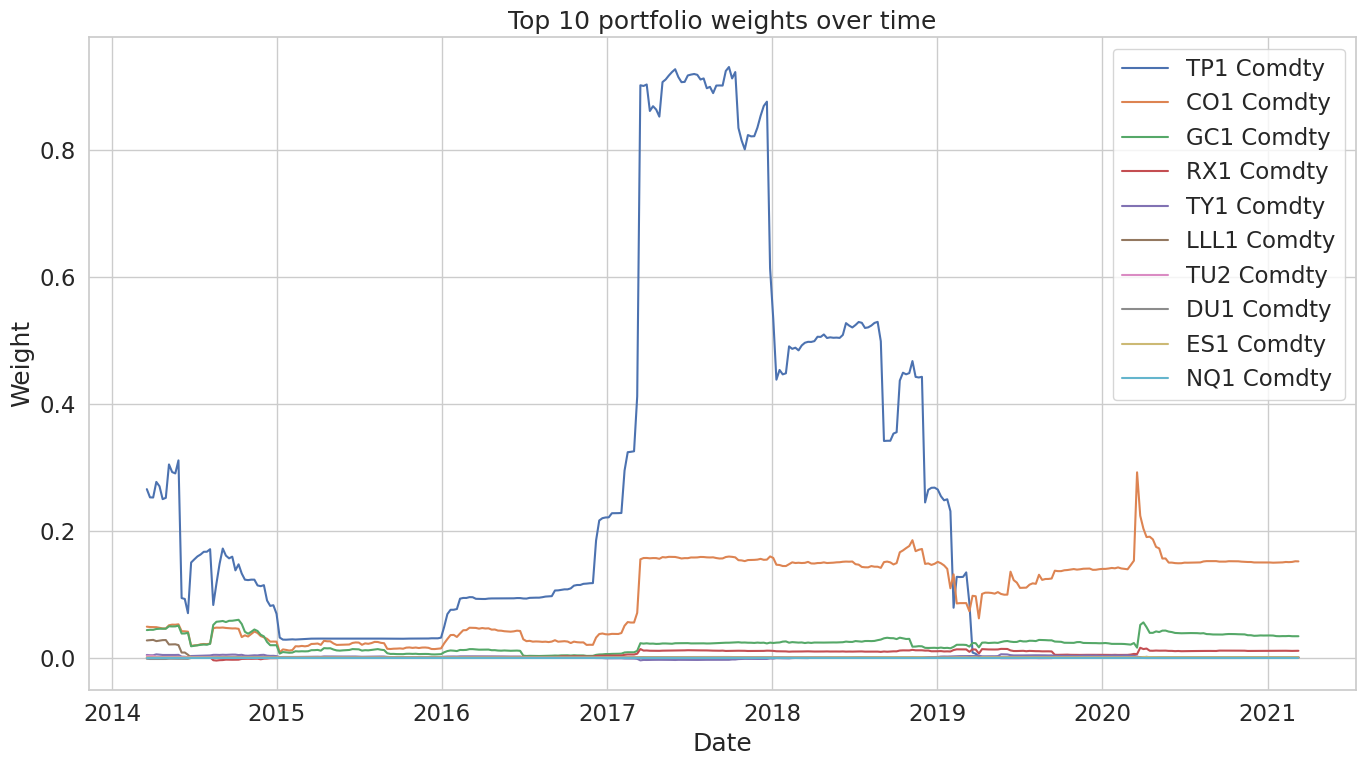

In [67]:
# Plot weights over time
weights_history = best_config_normalized['weights_history']
weights_df = pd.DataFrame(weights_history, index=best_config_normalized['replica_returns'].index)

# Get the column names from the original futures data
weights_df.columns = X.columns

# Plot the top 10 weights by absolute average value
top_weights = weights_df.abs().mean().sort_values(ascending=False).head(10).index
plt.figure(figsize=(14, 8))
for col in top_weights:
    plt.plot(weights_df[col], label=col)
plt.title('Top 10 portfolio weights over time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


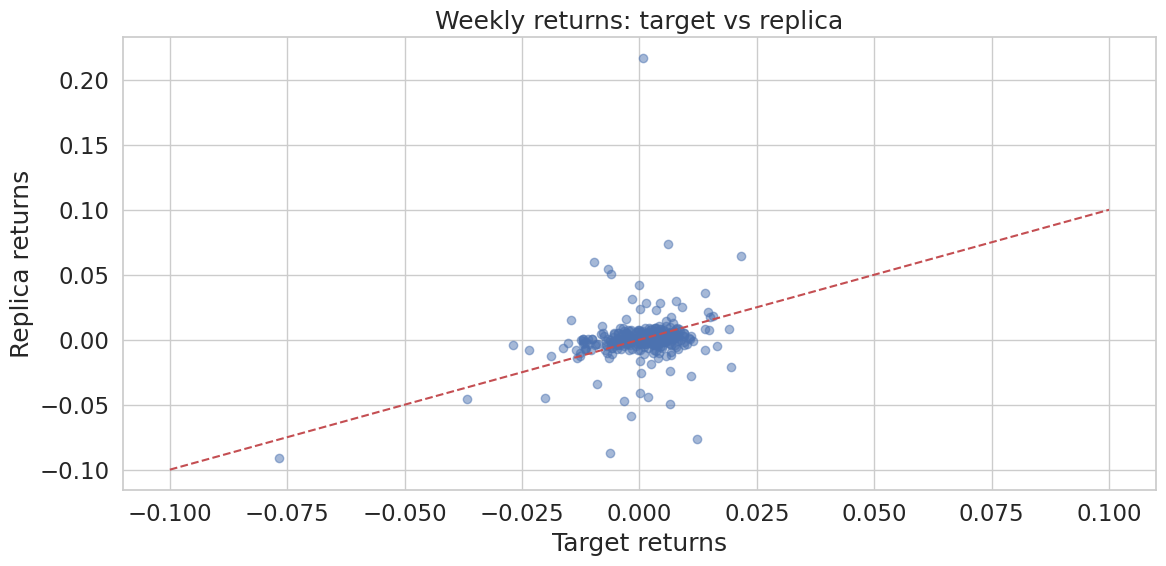

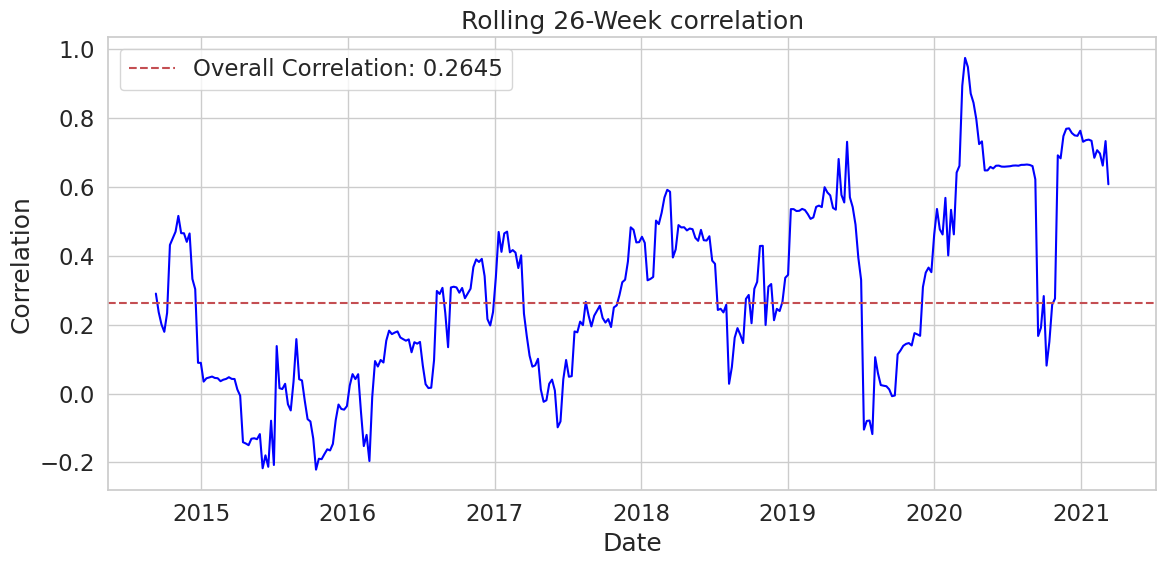

In [68]:
# Plot weekly returns
plt.figure(figsize=(12, 6))
plt.scatter(best_config_normalized['aligned_target'], best_config_normalized['replica_returns'], alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')  # Diagonal line
plt.title('Weekly returns: target vs replica')
plt.xlabel('Target returns')
plt.ylabel('Replica returns')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot rolling correlation
plt.figure(figsize=(12, 6))
rolling_corr = best_config_normalized['replica_returns'].rolling(window=26).corr(best_config_normalized['aligned_target'])
plt.plot(rolling_corr, color='blue')
plt.title('Rolling 26-Week correlation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.axhline(y=best_config_normalized['correlation'], color='r', linestyle='--',
            label=f'Overall Correlation: {best_config_normalized["correlation"]:.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# **HINTs**

### **Introduce transaction costs**
Consider 5 basis points (0.05%) per trade, it is a reasonable average value.

### **Try different algorithms**
* **Try different related models, such as OLS, Lasso, Ridge**, testing:
    * Different rolling windows.
    * Different rebalancing windows (every N weeks, eg 4 weeks, 12 weeks).
    * Different hyperparameters, eg lambda, Alpha.
    * some Futures selction before the regression.

* **Try a Kalman Filter**

If you have already studied **State Space Models** and the **Kalman Filter**, here’s a more advanced idea for portfolio replication.

##### Problem Setting

We want to replicate a **target portfolio return** using a dynamic linear model, where the **portfolio weights are unobservable** and potentially changing over time.

This naturally leads to a **linear multivariate Gaussian State-Space Model**:

#### State-Space representation

We define:

- $y_t$: target portfolio return from $t-1$ to $t$ = **observable scalar**.
- $x_t$: portfolio weights at time $t% = **unobservable vector**.
- $C_t$: observed asset returns (Futures contracts) — ** a vector**.

$
\begin{aligned}
x_t &= A x_{t-1} + B u_t \quad &\text{(state equation)} \\
y_t &= C_t x_t + D \varepsilon_t \quad &\text{(observation equation)}
\end{aligned}
$

---

#### Parameter (reasonable) choices

- $A = I$: identity matrix — assumes **weights follow a random walk**.
- $B$: diagonal matrix of process noise (std. dev. of innovations in weights).
- $C_t$: observed Futures returns at time $t$ .
- $D$: standard deviation of target portfolio return.

This setup assumes that weights evolve **slowly and stochastically**, while returns are a linear combination of the current weights and observable market data.


> 💡 Hint: Start with a Ridge regression (or similar) to **initialize the first weight vector**, then let the Kalman Filter take over.

---

- See: [What is the Kalman Filter? (MathWorks)](https://it.mathworks.com/help/econ/what-is-the-kalman-filter.html)
- See also: [SSRN Working Paper – Replicating Hedge Funds with Kalman Filters](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1325190)
